In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import re
from datetime import datetime

In [2]:
import os,sys
sys.path.insert(0, os.path.abspath('.'))
print(sys.path)
from trace import Request, TraceConfig, generate_synthetic_reqs


['/home/shanyu/sglang/benchmark/multi-model', '/home/shanyu/sglang/benchmark/multi-model', '/home/shanyu/miniconda3/envs/sgl/lib/python39.zip', '/home/shanyu/miniconda3/envs/sgl/lib/python3.9', '/home/shanyu/miniconda3/envs/sgl/lib/python3.9/lib-dynload', '', '/home/shanyu/miniconda3/envs/sgl/lib/python3.9/site-packages', '__editable__.sglang-0.2.10.finder.__path_hook__', '/home/shanyu/miniconda3/envs/sgl/lib/python3.9/site-packages/setuptools/_vendor']


In [3]:
import pandas as pd

In [4]:
MODELS = ["meta-llama/Llama-2-7b-chat-hf", "mistralai/Mistral-7B-Instruct-v0.2"]
SEED = 42
MODES = ["collocate", "single-model"]
SWAP_MODES = ["swap-baseline", "swap-enhanced"]

In [5]:
def get_file_paths(dir_name, file_type, trace_config, days=["0826", "0827"]):
    file_paths = {}
    for mode in MODES:
        file_checked = []
        for day in days[::-1]:
            filename = f"{day}_{mode}-hiddel_layers-24_duration_{trace_config.duration}_req_rate-{trace_config.req_rate}_alpha-{trace_config.alpha}_cv-{trace_config.cv}_input-{trace_config.input_range[0]}-{trace_config.input_range[1]}_output-{trace_config.output_range[0]}-{trace_config.output_range[1]}.{file_type}"
            path = os.path.join(dir_name, filename)
            file_checked.append(path)
            if os.path.exists(path):
                file_paths[mode] = path
                break
        assert mode in file_paths, f"File not found for {mode} with days {days}, checked {file_checked}"
    return file_paths


In [6]:
def get_trace_config(req_rate, cv, alpha, slo=None):
    trace_config = TraceConfig(
        req_rate=req_rate,
        duration=60*5,
        input_range=[8, 1024],
        output_range=[8, 512],
        model_paths=MODELS,
        seed=SEED,
        alpha=alpha,
        cv=cv,
        slo=slo
    )
    return trace_config

In [7]:
def get_old_server_files(trace_config, days=["0826", "0827", "0828", "0829"], modes=MODES):
    dir_name = "server-logs"
    file_type = "log"
    server_file_paths = {}
    for mode in modes:
        assert mode in MODES, f"Mode {mode} not in {MODES}"
        file_checked = []
        for day in days[::-1]:
            filename = f"{day}_{mode}-hiddel_layers-24_duration-{trace_config.duration}_req_rate-{trace_config.req_rate}_alpha-{trace_config.alpha}_cv-{trace_config.cv}_input-{trace_config.input_range[0]}-{trace_config.input_range[1]}_output-{trace_config.output_range[0]}-{trace_config.output_range[1]}.{file_type}"
            path = os.path.join(dir_name, filename)
            file_checked.append(path)
            if os.path.exists(path):
                server_file_paths[mode] = path
                break
        assert mode in server_file_paths, f"File not found for {mode} with days {days}, checked {file_checked}"
    return server_file_paths

In [8]:
def get_new_server_files(trace_config, days=["0828", "0829", "0830"], modes=SWAP_MODES):
    dir_name = "server-logs"
    file_type = "log"
    server_file_paths = {}
    for mode in modes:
        file_checked = []
        for day in days[::-1]:
            filename = f"{day}_{mode}_duration-{trace_config.duration}_req_rate-{trace_config.req_rate}_alpha-{trace_config.alpha}_cv-{trace_config.cv}_slo-{trace_config.slo}.{file_type}"
            path = os.path.join(dir_name, filename)
            file_checked.append(path)
            if os.path.exists(path):
                server_file_paths[mode] = path
                break
        assert mode in server_file_paths, f"File not found for {mode} with days {days}, checked {file_checked}"
    return server_file_paths

In [9]:
def get_old_results(trace_config, days=["0823", "0824"], metrics=["request_throughput"], modes=MODES):
    dir_name = "benchmark-results"
    file_type = "json"
    results = {}
    for metric in metrics:
        results[metric] = {}
    for mode in modes:
        file_checked = []
        for day in days[::-1]:
            filename = f"{day}_{mode}-hiddel_layers-24_duration_{trace_config.duration}_req_rate-{trace_config.req_rate}_alpha-{trace_config.alpha}_cv-{trace_config.cv}_input-{trace_config.input_range[0]}-{trace_config.input_range[1]}_output-{trace_config.output_range[0]}-{trace_config.output_range[1]}.{file_type}"
            path = os.path.join(dir_name, filename)
            file_checked.append(path)
            if os.path.exists(path):
                with open(path, "r") as f:
                    # read the last line results
                    for line in f:
                        pass
                    result = json.loads(line)
                    # result = json.loads(f.readline())
                    for metric in metrics:
                        results[metric][mode] = result[metric]
                break
        assert mode in results[metrics[0]], f"File not found for {mode} with days {days}, checked {file_checked}"
    return results

In [10]:
def get_new_results(trace_config, days=["0828", "0829"], modes=SWAP_MODES, metrics=["request_throughput"], restrict_slo=False):
    dir_name = "benchmark-results"
    file_type = "json"
    results = {}
    if restrict_slo:
        slos = [trace_config.slo]
    else:
        slos = [60*3, 60*2, 100]
    for metric in metrics:
        results[metric] = {}
    for mode in modes:
        file_checked = []
        for day in days[::-1]:
            for slo in slos:
                filename = f"{day}_{mode}_duration-{trace_config.duration}_req_rate-{trace_config.req_rate}_alpha-{trace_config.alpha}_cv-{trace_config.cv}_slo-{slo}.{file_type}"
                path = os.path.join(dir_name, filename)
                file_checked.append(path)
                if os.path.exists(path):
                    with open(path, "r") as f:
                        # read the last line results
                        for line in f:
                            pass
                        result = json.loads(line)
                        # result = json.loads(f.readline())
                        for metric in metrics:
                            results[metric][mode] = result[metric]
                    break
            if mode in results[metrics[0]]:
                break
        assert mode in results[metrics[0]], f"File not found for {mode} with days {days}, checked {file_checked}"
    return results

## Throughputs Analysis

### Proformance vs Request Rate and alpha (cv = 1)

In [11]:
def merge_dicts(dict1, dict2):
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged:
            merged[key].update(value)
        else:
            merged[key] = value
    return merged

In [12]:
result_data = {}
metrics = ["request_throughput", "mean_e2e_latency_ms", "median_e2e_latency_ms"]
for metric in metrics:
    result_data[metric] = []

req_rates = [1, 2, 4, 8, 12, 16, 20, 24]
cv = 1
alphas = [0.1, 0.3, 0.6, 1]
for req_rate in req_rates:
    for alpha in alphas:
        trace_config = get_trace_config(req_rate, cv, alpha)
        if req_rate == 12 and alpha in [0.1, 0.3, 1]:
            # get collocate from the new results
            collocate_results = get_new_results(trace_config, days=["0829", "0830"], modes=["collocate"], metrics=metrics)
            singe_results = get_old_results(trace_config, days=["0826", "0827", "0828", "0829"], modes=["single-model"], metrics=metrics)
            collocate_single_results = merge_dicts(collocate_results, singe_results)
        else:
            collocate_single_results = get_old_results(trace_config, days=["0826", "0827", "0828", "0829"], modes=["collocate", "single-model"], metrics=metrics)
        
        swap_results = get_new_results(trace_config, days=["0828", "0829"], modes=["swap-enhanced"], metrics=metrics)
        if req_rate < 12:
            swap_baseline = get_new_results(trace_config, days=["0828", "0829"], modes=["swap-baseline"], metrics=metrics)
            swap_results = merge_dicts(swap_results, swap_baseline)
        
        for metric in metrics:
            data = dict(req_rate=req_rate, alpha=alpha, cv=cv, **collocate_single_results[metric], **swap_results[metric])
            result_data[metric].append(data)
            print(data)
        

            
        # results = get_results(trace_config, days=["0826", "0827", "0828", "0829"])

        # swap_results = get_swap_results(trace_config, days=["0828", "0829"], modes=["swap-enhanced"])
        # if req_rate < 12:
        #     swap_baseline = get_swap_results(trace_config, days=["0828", "0829"], modes=["swap-baseline"])
        #     swap_results["swap-baseline"] = swap_baseline["swap-baseline"]
        # request_tputs.update(swap_results)

        # result_data.append(dict(req_rate=req_rate, alpha=alpha, cv=cv, **request_tputs))
        # print(f"req_rate: {req_rate}, alpha: {alpha}, cv: {cv}")
        # print(request_tputs)
        # print("")


{'req_rate': 1, 'alpha': 0.1, 'cv': 1, 'collocate': 0.9140465201295735, 'single-model': 0.9143286397924055, 'swap-enhanced': 0.9075201744022843, 'swap-baseline': 0.8286800413275216}
{'req_rate': 1, 'alpha': 0.1, 'cv': 1, 'collocate': 4497.727377122888, 'single-model': 3325.135347340195, 'swap-enhanced': 17391.377578386648, 'swap-baseline': 26730.463386378156}
{'req_rate': 1, 'alpha': 0.1, 'cv': 1, 'collocate': 4013.0308249936206, 'single-model': 3421.3072700003977, 'swap-enhanced': 5347.660045998055, 'swap-baseline': 5274.536263008486}
{'req_rate': 1, 'alpha': 0.3, 'cv': 1, 'collocate': 0.9029820461441055, 'single-model': 0.914250798503693, 'swap-enhanced': 0.8627681718369428, 'swap-baseline': 0.7376796578629565}
{'req_rate': 1, 'alpha': 0.3, 'cv': 1, 'collocate': 5743.7149240295785, 'single-model': 3304.028610243283, 'swap-enhanced': 15735.553773340556, 'swap-baseline': 31022.712466480636}
{'req_rate': 1, 'alpha': 0.3, 'cv': 1, 'collocate': 5285.766196000623, 'single-model': 3378.8266

In [13]:
dfs = {}
for metric in metrics:
    df = pd.DataFrame(result_data[metric])
    dfs[metric] = df

In [30]:
def plot_metric_vs_req_rate(df, metric, req_rate_max=24):
    # Get the unique alpha values
    alpha_values = sorted(df['alpha'].unique())

    # Create a 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()  # Flatten the 2x2 array for easier iteration

    # Loop through each alpha value and corresponding subplot axis
    for i, alpha in enumerate(alpha_values):
        subset = df[(df['alpha'] == alpha) & (df['cv'] == 1) & (df['req_rate'] <= req_rate_max)]
        ax = axes[i]  # Select the current subplot
        
        # Plot the data
        # ax.plot(subset['req_rate'], subset['swap-baseline'], label='swap-baseline', marker='o')
        if 'swap-baseline' in subset.columns:
            if metric.endswith("throughput"):
                func = max
            else:
                func = min
            swap_result = []
            for i in subset.index:
                if not np.isnan(subset.loc[i, 'swap-baseline']):
                    swap_result.append(func(subset.loc[i, 'swap-enhanced'], subset.loc[i, 'swap-baseline']))
                else:
                    swap_result.append(subset.loc[i, 'swap-enhanced'])
            


                # subset.loc[i, 'swap-enhanced'] = func(subset.loc[i, 'swap-enhanced'], subset.loc[i, 'swap-baseline'])
                # swap_result = max(subset['swap-enhanced'], subset['swap-baseline'])
            # else:
            #     swap_result = min(subset['swap-enhanced'], subset['swap-baseline'])
        else:
            swap_result = subset['swap-enhanced']
        ax.plot(subset['req_rate'], swap_result, label='swap', marker='o')
        ax.plot(subset['req_rate'], subset['collocate'], label='collocate', marker='x')
        ax.plot(subset['req_rate'], subset['single-model'], label='single-model', marker='s')

        # Set labels and title for each subplot
        ax.set_xlabel('Request Rate')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} vs. Request Rate (alpha={alpha}, cv=1)')
        ax.legend()
        ax.grid(True)

    # add title 
    plt.suptitle(f'{metric} vs. Request Rate', fontsize=16)
    # Adjust layout to avoid overlapping
    plt.tight_layout()
    plt.show()


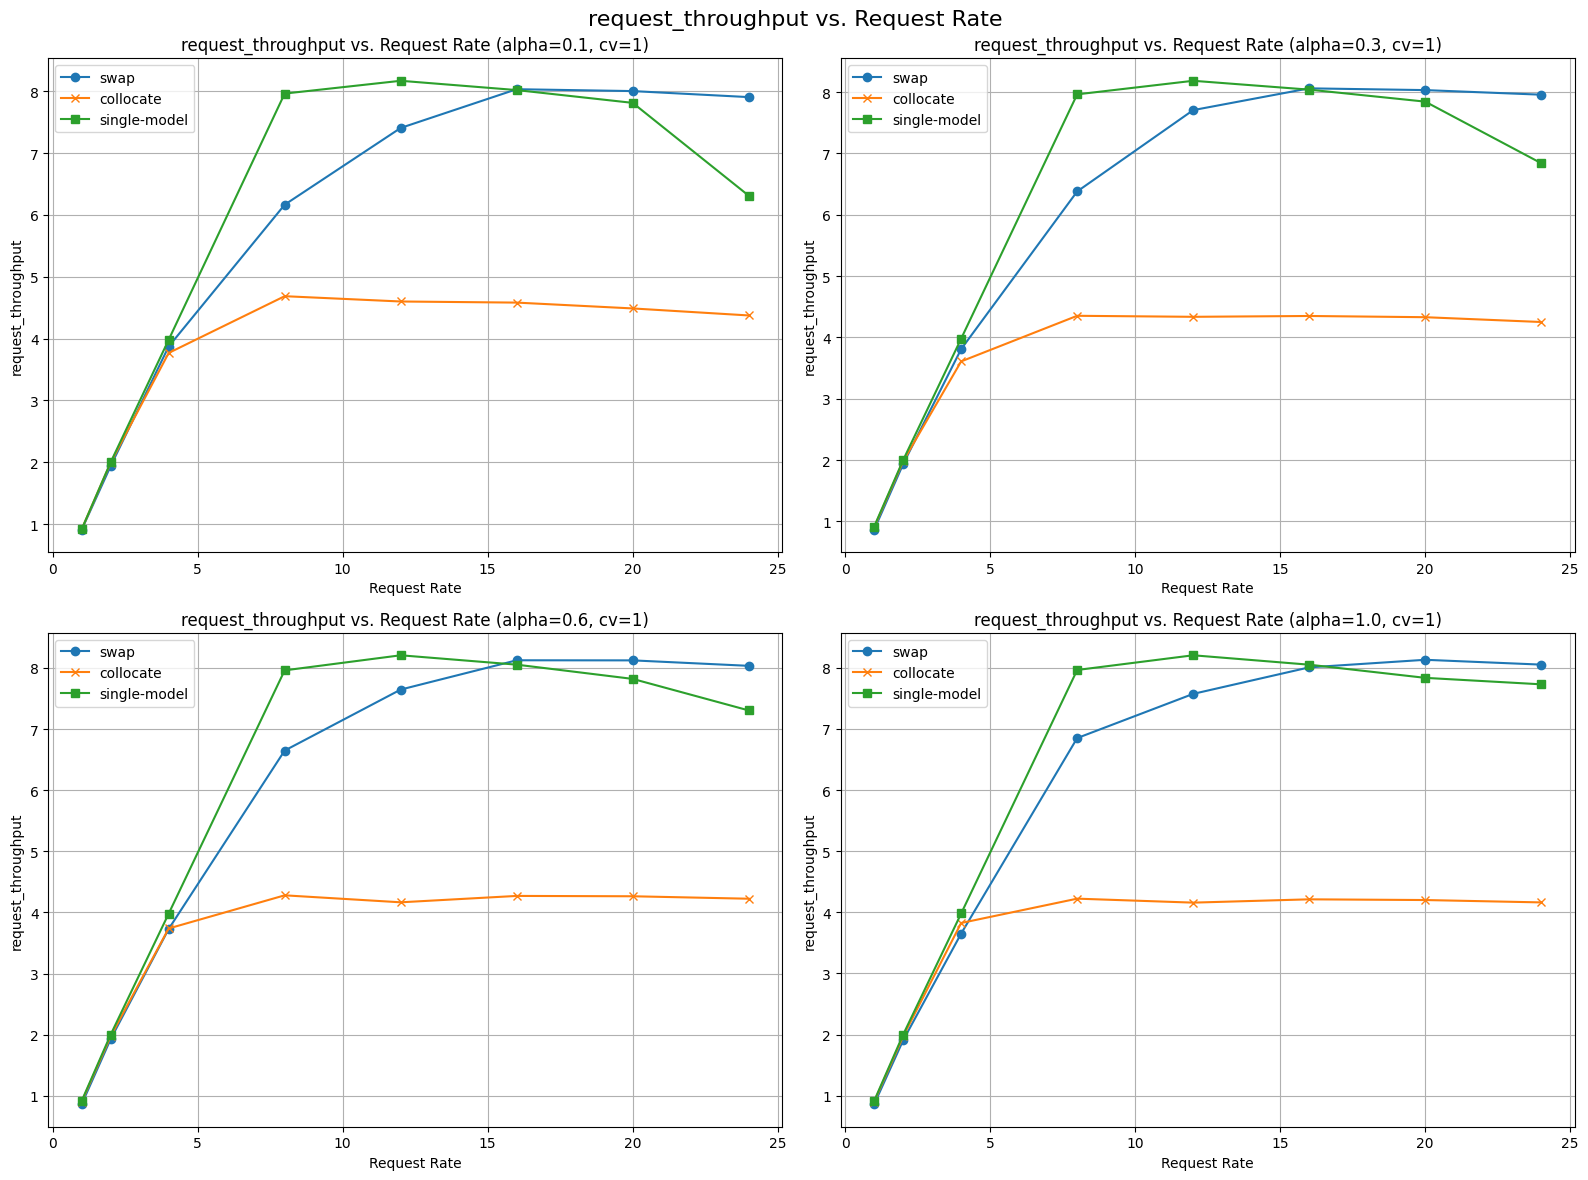

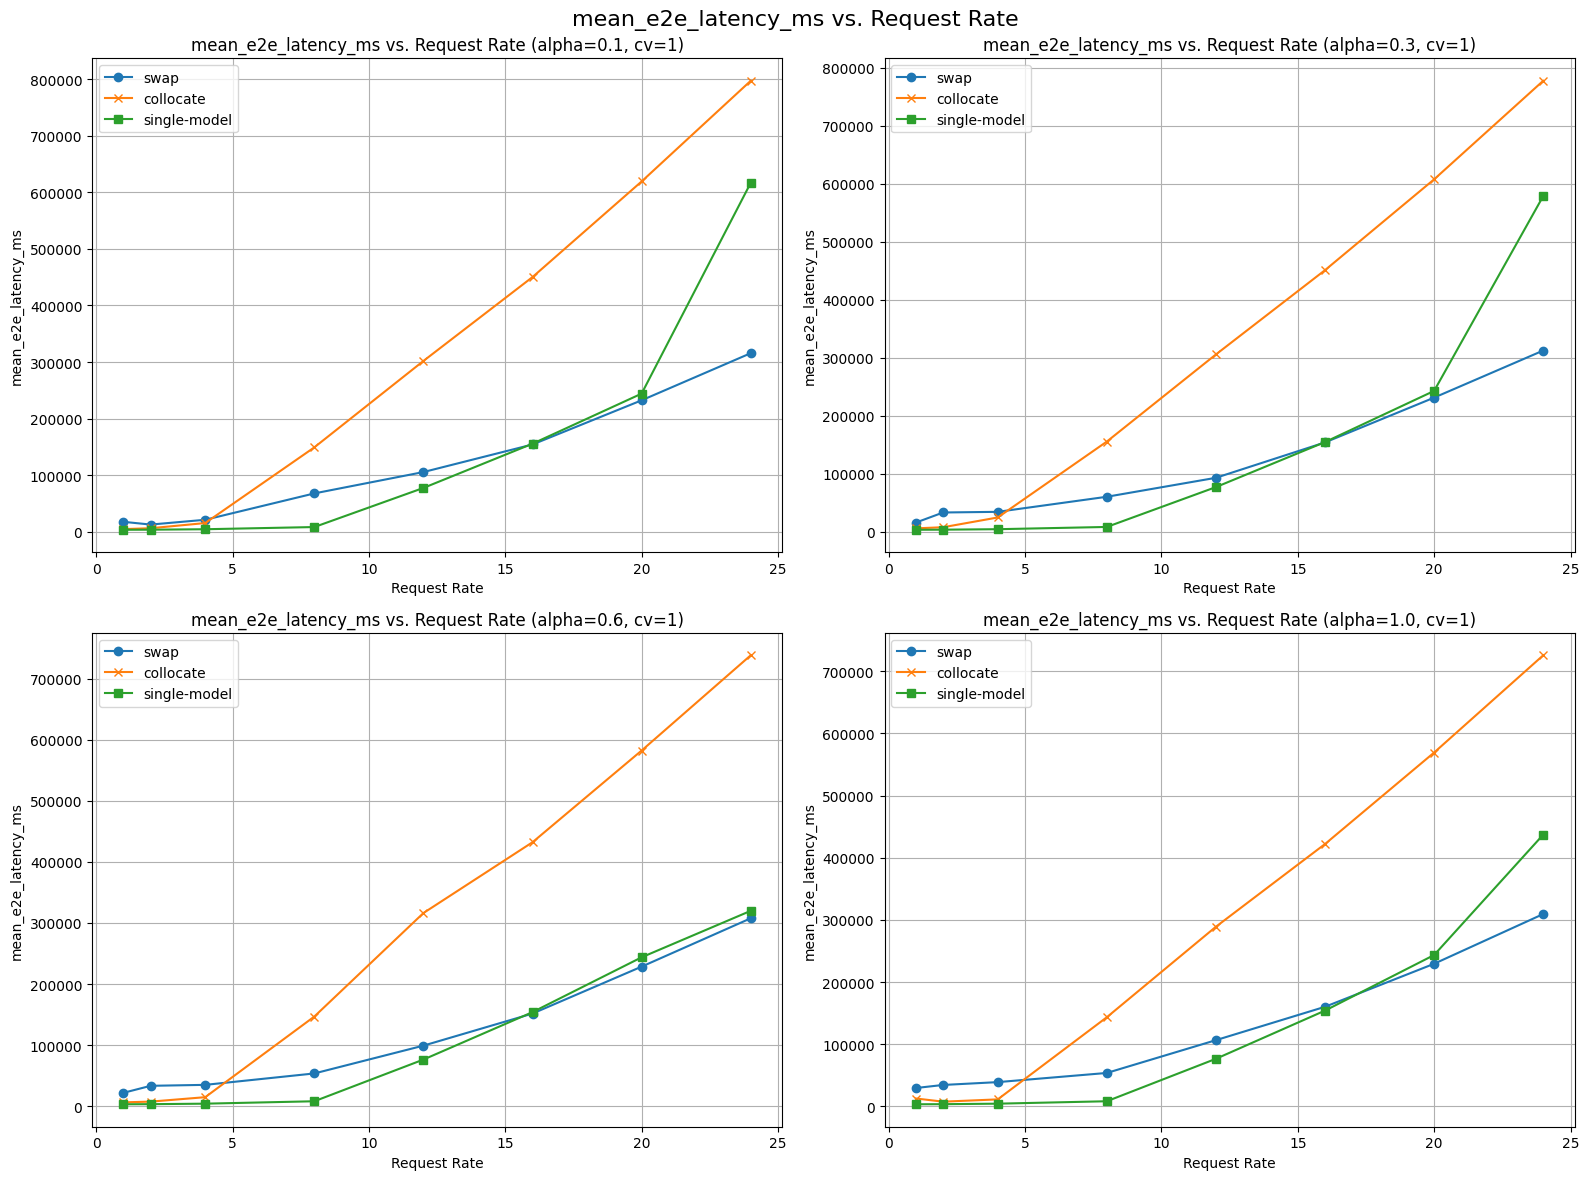

In [31]:
for metric in metrics:
    plot_metric_vs_req_rate(dfs[metric], metric)

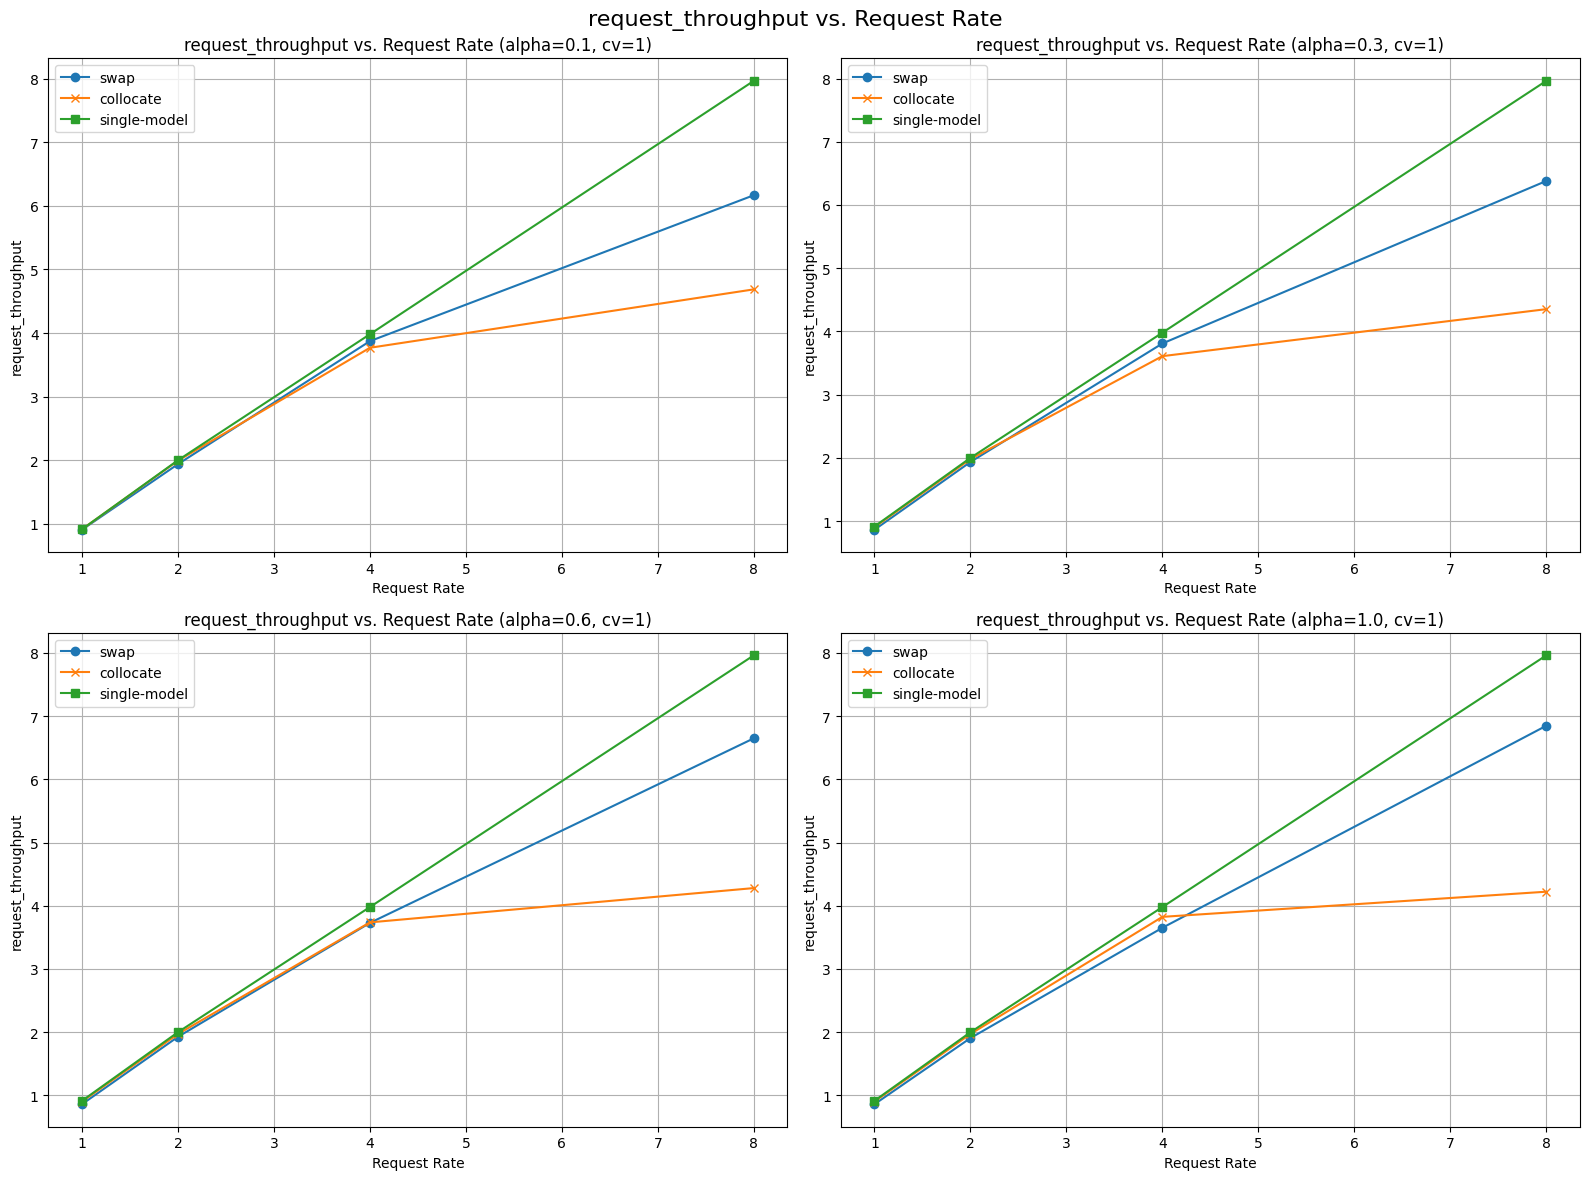

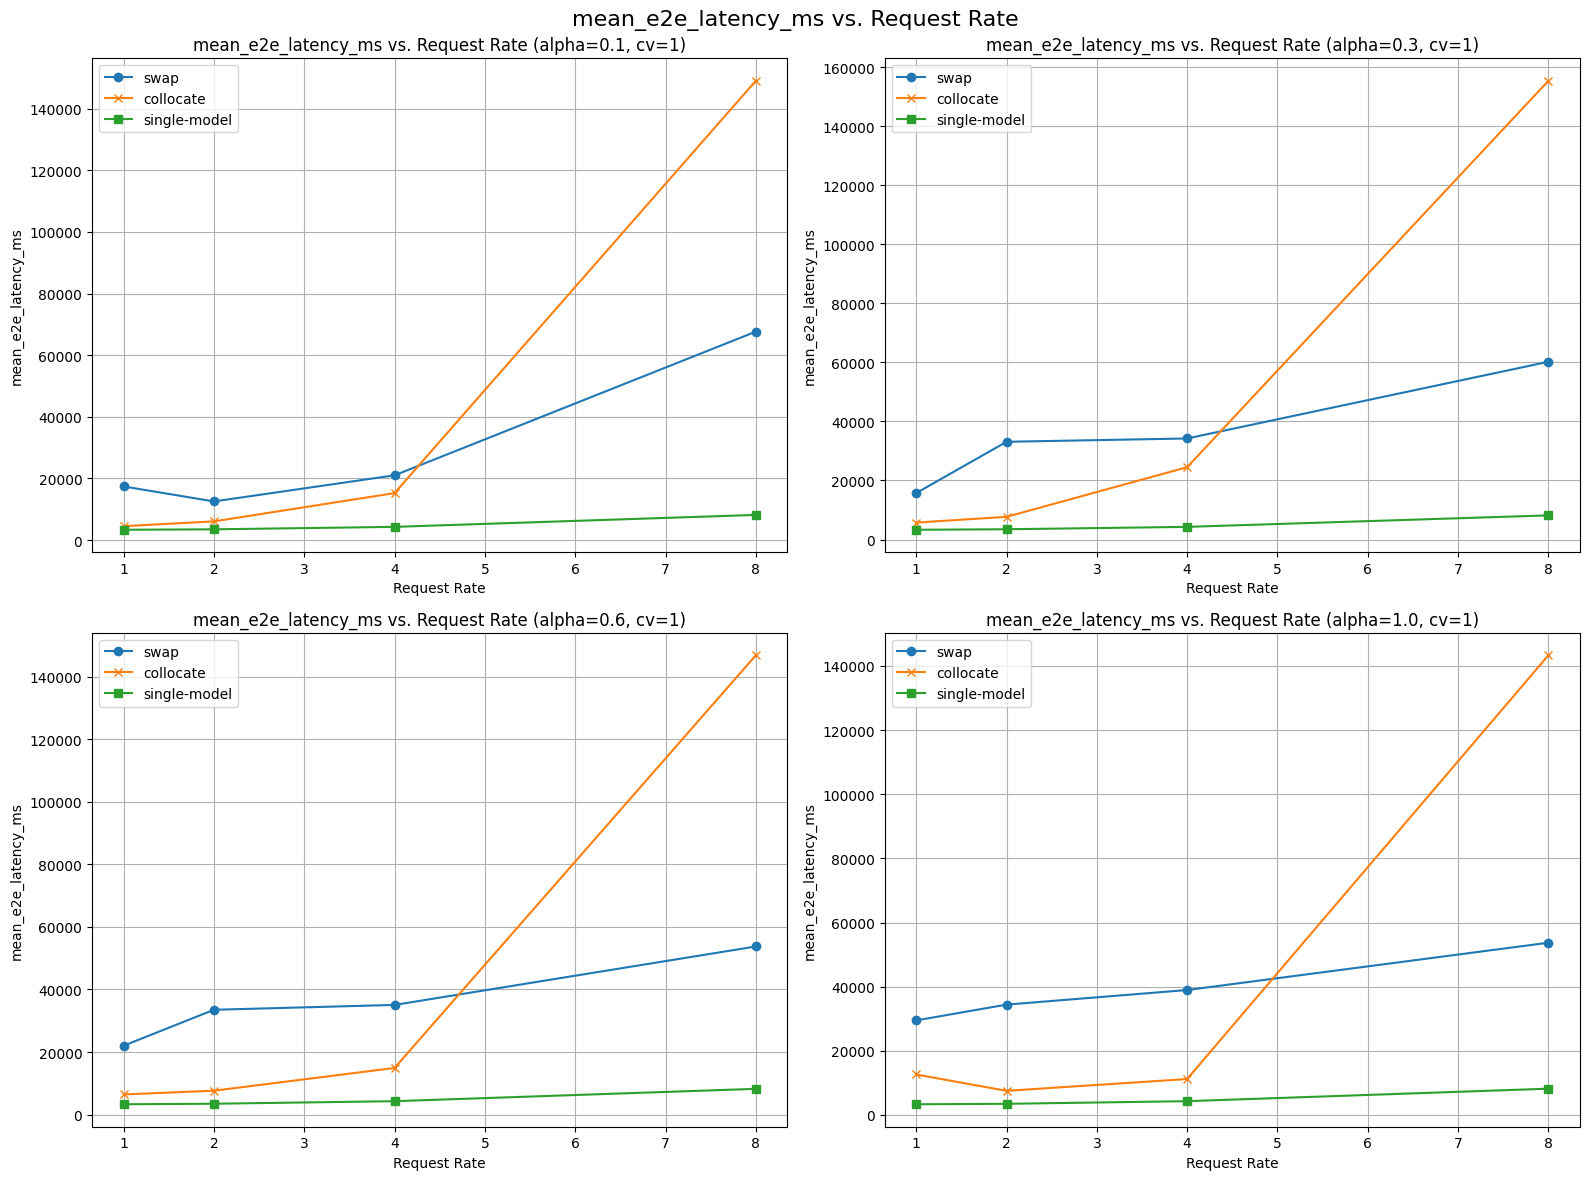

In [32]:
for metric in metrics:
    plot_metric_vs_req_rate(dfs[metric], metric, req_rate_max=8)

In [17]:
swap_result_data = {}
metrics=["request_throughput", "mean_e2e_latency_ms"]
for metric in metrics:
    swap_result_data[metric] = []

# req_rates = [1, 2, 4, 8, 12, 16, 20, 24]
req_rates = [1, 2, 4, 8, 12]
cv = 1
alphas = [0.1, 0.3, 0.6, 1]
slos = [100, 60*2, 60*3]
for req_rate in req_rates:
    for alpha in alphas:
        if req_rate == 12 and alpha > 0.3:
            continue
        for slo in slos:
            trace_config = get_trace_config(req_rate, cv, alpha, slo=slo)
            results = get_new_results(trace_config, days=["0828", "0829"], modes=SWAP_MODES, metrics=metrics, restrict_slo=True)
            for metric in metrics:
                data = dict(req_rate=req_rate, alpha=alpha, cv=cv, slo=slo, **results[metric])
                swap_result_data[metric].append(data)
                print(data)

{'req_rate': 1, 'alpha': 0.1, 'cv': 1, 'slo': 100, 'swap-baseline': 0.8877687952322281, 'swap-enhanced': 0.8941574085018396}
{'req_rate': 1, 'alpha': 0.1, 'cv': 1, 'slo': 100, 'swap-baseline': 8838.324544057445, 'swap-enhanced': 8236.242897336197}
{'req_rate': 1, 'alpha': 0.1, 'cv': 1, 'slo': 120, 'swap-baseline': 0.8942524006416163, 'swap-enhanced': 0.9141135642962405}
{'req_rate': 1, 'alpha': 0.1, 'cv': 1, 'slo': 120, 'swap-baseline': 12599.42070875123, 'swap-enhanced': 8385.68834832976}
{'req_rate': 1, 'alpha': 0.1, 'cv': 1, 'slo': 180, 'swap-baseline': 0.8286800413275216, 'swap-enhanced': 0.9075201744022843}
{'req_rate': 1, 'alpha': 0.1, 'cv': 1, 'slo': 180, 'swap-baseline': 26730.463386378156, 'swap-enhanced': 17391.377578386648}
{'req_rate': 1, 'alpha': 0.3, 'cv': 1, 'slo': 100, 'swap-baseline': 0.868932850788807, 'swap-enhanced': 0.8688861702038247}
{'req_rate': 1, 'alpha': 0.3, 'cv': 1, 'slo': 100, 'swap-baseline': 12424.737834897049, 'swap-enhanced': 9587.651840480201}
{'req_r

In [18]:
swap_dfs = {}
for metric in metrics:
    swap_df = pd.DataFrame(swap_result_data[metric])
    swap_dfs[metric] = swap_df

In [19]:

def plot_slo(df_swap, metric, req_rates=[1, 2]):
    # plot histogram for each slo value for a fixed alpha
    alpha_values = sorted(df_swap['alpha'].unique())
    # req_rates = sorted(df_swap['req_rate'].unique())
    slos = sorted(df_swap['slo'].unique())

    fig, axes = plt.subplots(len(alpha_values), len(req_rates), figsize=(16, 12))
    bar_width = 0.35
    x_positions = np.arange(len(slos))

    for i, alpha in enumerate(alpha_values):
        for j, req_rate in enumerate(req_rates):
            subset = df_swap[(df_swap['alpha'] == alpha) & (df_swap['cv'] == 1) & (df_swap['req_rate'] == req_rate)]
            ax = axes[i, j]

            if req_rate == 12 and alpha > 0.3:
                continue
            # Plot the data
            baseline_bars = ax.bar(x_positions - bar_width/2, subset["swap-baseline"], width=bar_width, label='swap-baseline', color='blue')
            enhanced_bars = ax.bar(x_positions + bar_width/2, subset["swap-enhanced"], width=bar_width, label='swap-enhanced', color='green')

            # Add labels, title, and legend
            ax.set_xlabel('SLO Values')
            ax.set_ylabel(metric)
            ax.set_title(f'alpha={alpha}, req_rate={req_rate})')

            ax.set_xticks(x_positions)
            ax.set_xticklabels(slos)
            ax.legend()

            if metric.endswith("throughput"):
                y_max = max(subset["swap-baseline"].max(), subset["swap-enhanced"].max()) + 1.5
                ax.set_yticks(np.arange(0, y_max))

            for bar in baseline_bars:
                yval = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.2f}', ha='center', va='bottom')
            
            for bar in enhanced_bars:
                yval = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.2f}', ha='center', va='bottom')

            ax.grid(True)    

    # add title
    plt.suptitle(f'{metric} vs. SLO Values', fontsize=16)
    plt.tight_layout()
    plt.show()



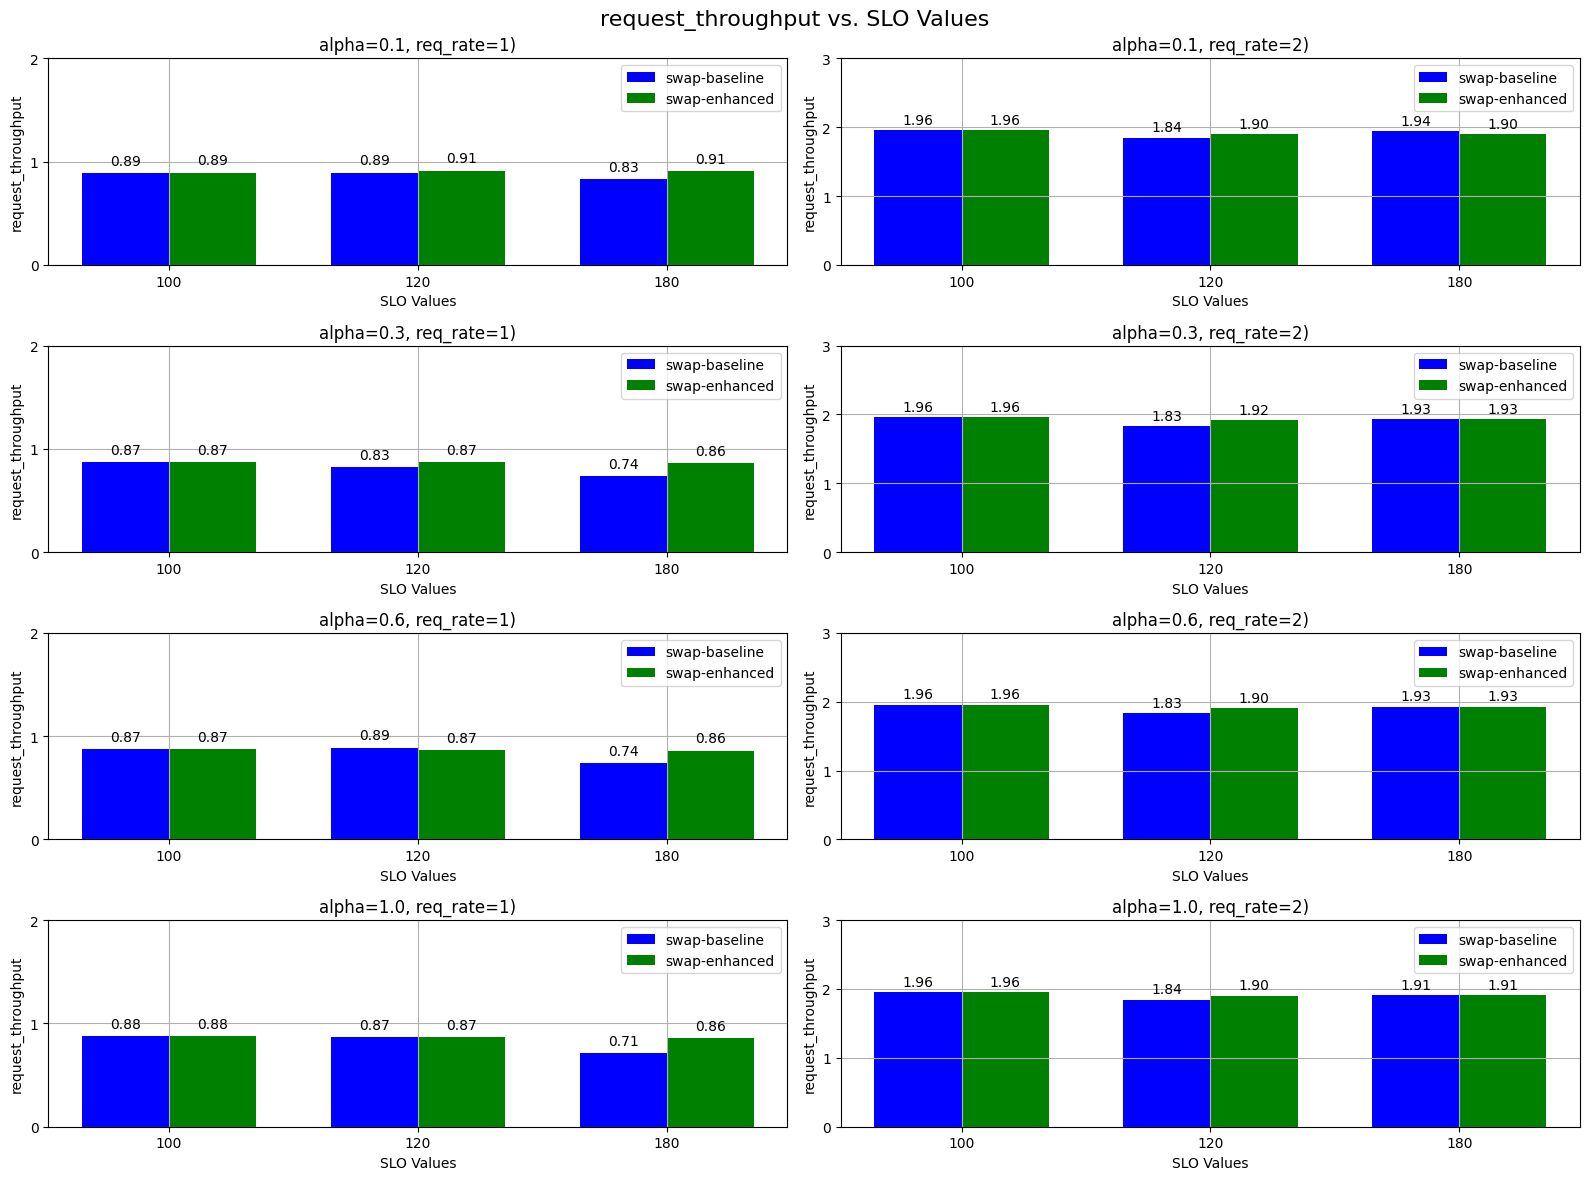

In [20]:
metric = metrics[0]
plot_slo(swap_dfs[metric], metric, req_rates=[1, 2])

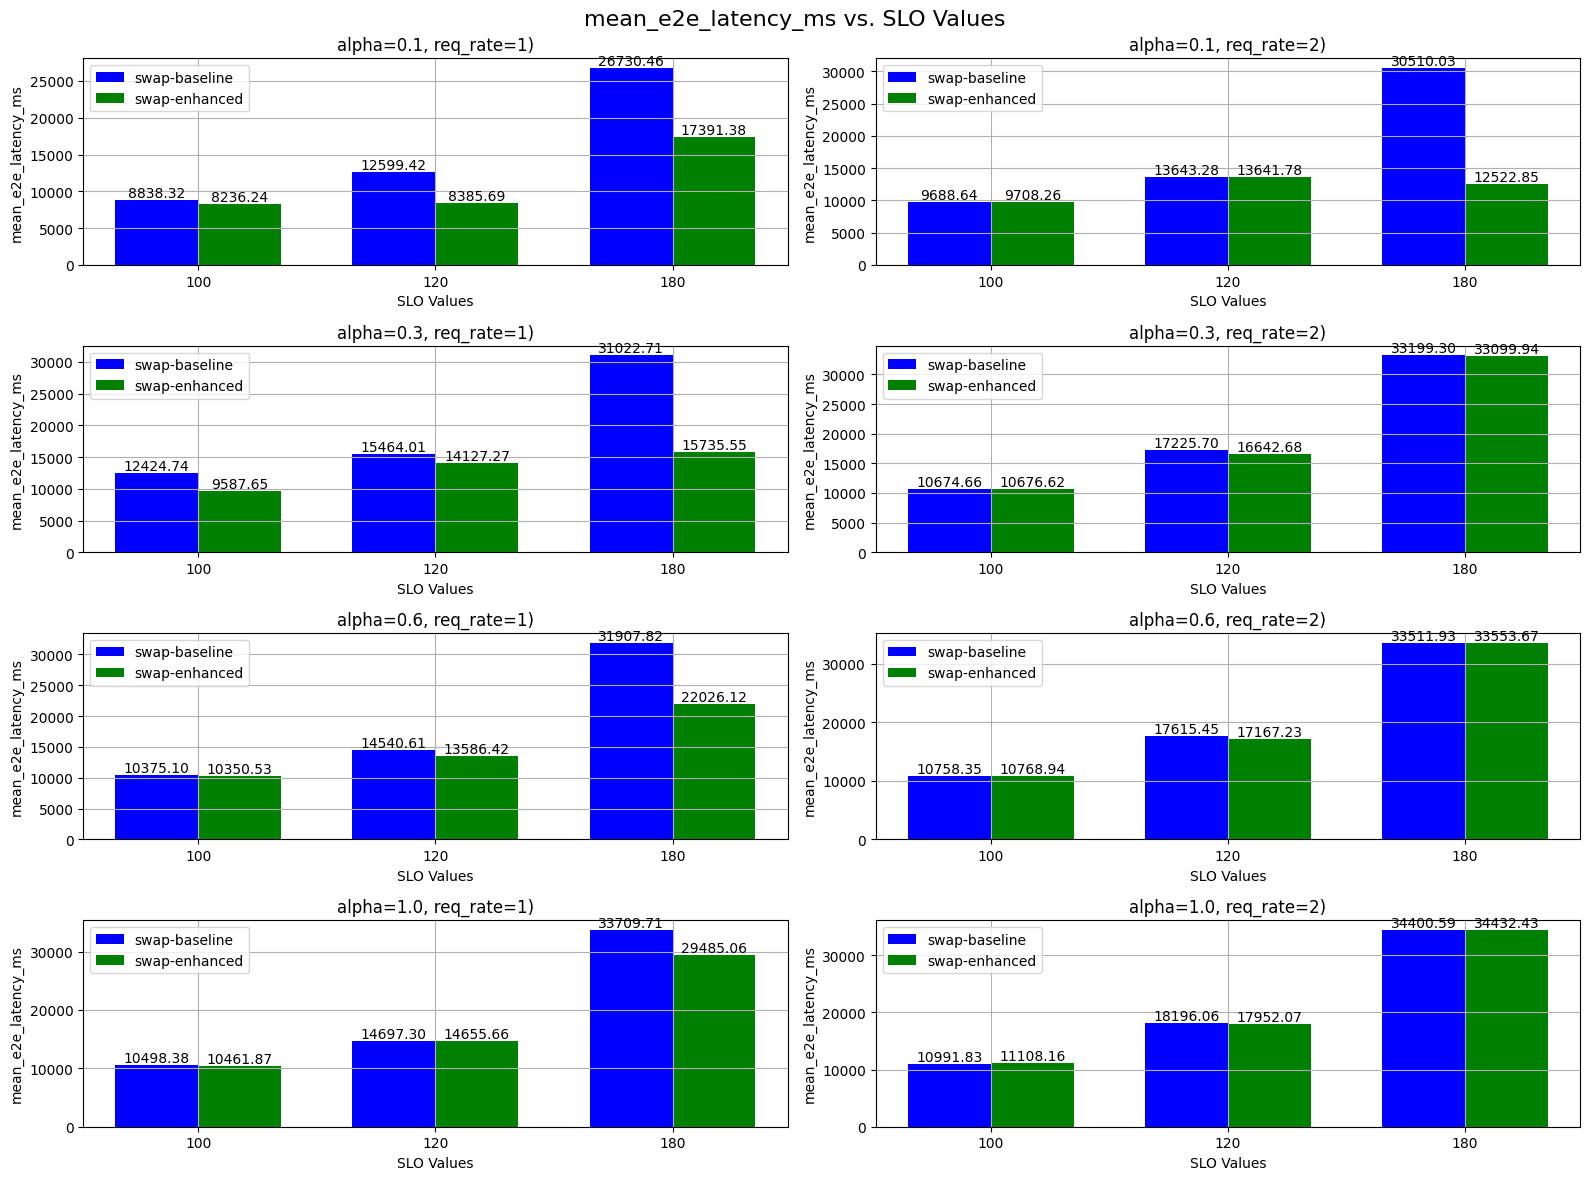

In [21]:
metric = metrics[1]
plot_slo(swap_dfs[metric], metric, req_rates=[1, 2])

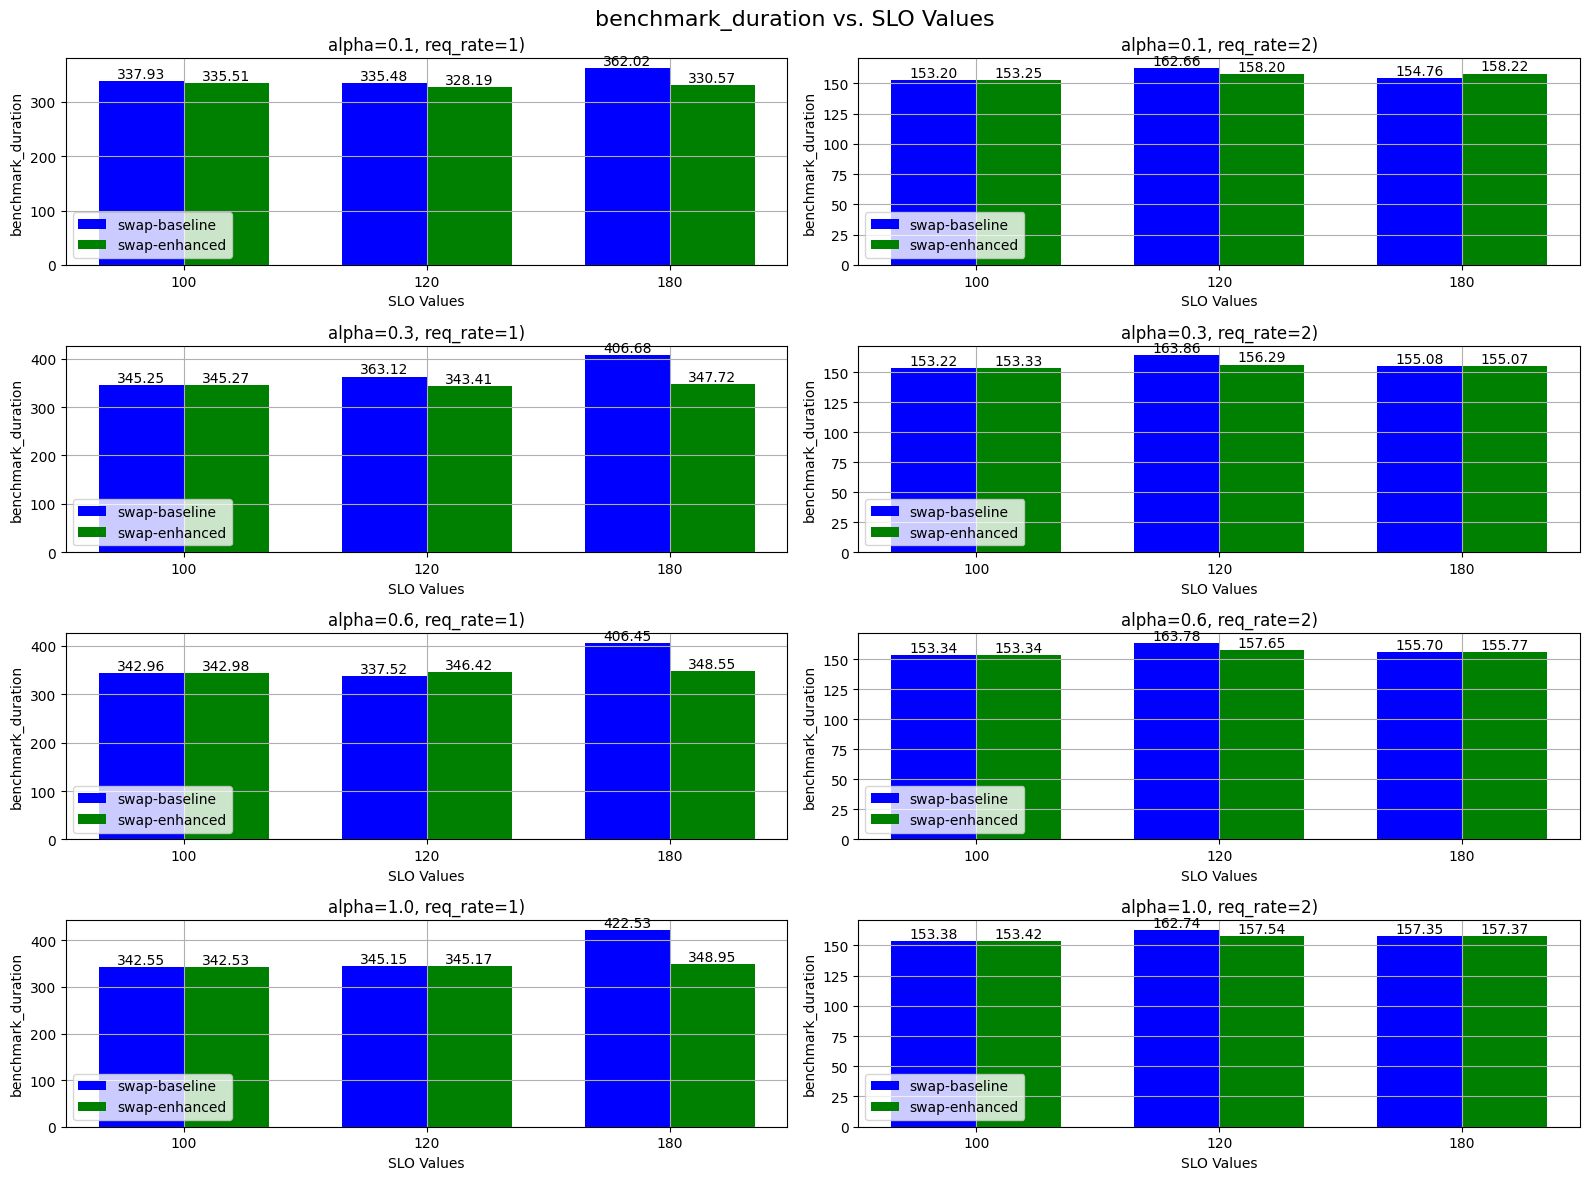

In [29]:
from copy import deepcopy

duration_df = deepcopy(swap_dfs[metrics[0]])
duration_df['duration'] = 60*5
duration_df["swap-baseline_duration"] = duration_df["duration"]/duration_df["swap-baseline"]
duration_df["swap-enhanced_duration"] = duration_df["duration"]/duration_df["swap-enhanced"]
# delete the duration column
del duration_df["duration"]
del duration_df["swap-baseline"]
del duration_df["swap-enhanced"]
duration_df.rename(columns={"swap-baseline_duration": "swap-baseline", "swap-enhanced_duration": "swap-enhanced"}, inplace=True)
plot_slo(duration_df, "benchmark_duration", req_rates=[1, 2])

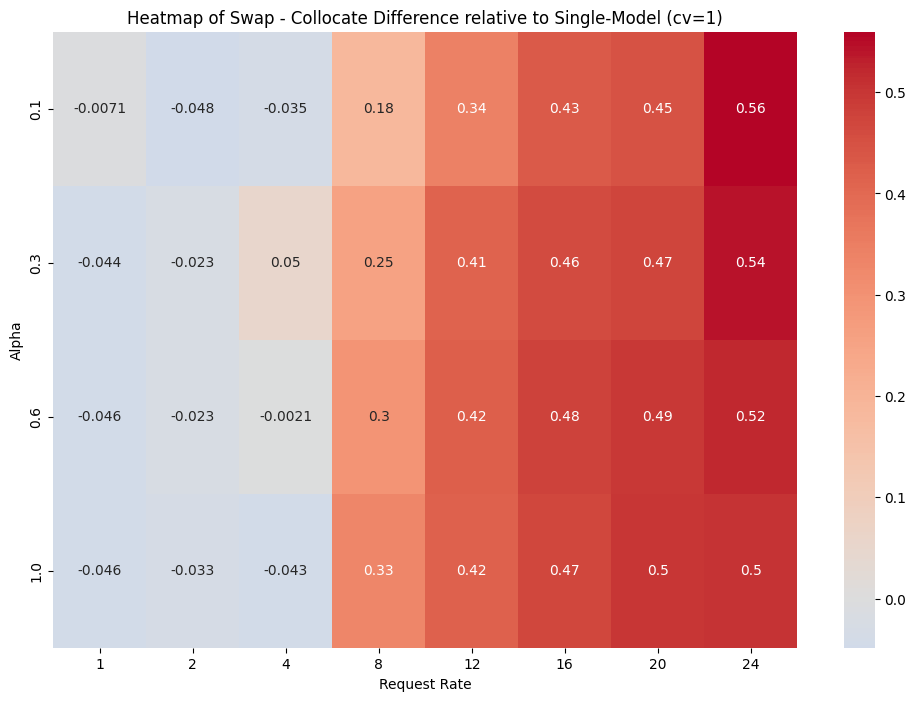

In [33]:
import seaborn as sns

tput_df = dfs["request_throughput"]
tput_df['swap_relative'] = tput_df['swap-enhanced'] / tput_df['single-model']
tput_df['collocate_relative'] = tput_df['collocate'] / tput_df['single-model']
tput_df['swap_collocate_relative_diff'] = tput_df['swap_relative'] - tput_df['collocate_relative']

pivot_table = tput_df.pivot_table(index='alpha', columns='req_rate', values='swap_collocate_relative_diff')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of Swap - Collocate Difference relative to Single-Model (cv=1)')
plt.xlabel('Request Rate')
plt.ylabel('Alpha')
plt.show()


In [37]:
swap_dfs["request_throughput"]

,req_rate,alpha,cv,slo,swap-baseline,swap-enhanced
0,1,0.1,1,100,0.887769,0.894157
1,1,0.1,1,120,0.894252,0.914114
2,1,0.1,1,180,0.828680,0.907520
3,1,0.3,1,100,0.868933,0.868886
4,1,0.3,1,120,0.826175,0.873601
5,1,0.3,1,180,0.737680,0.862768
6,1,0.6,1,100,0.874727,0.874683
7,1,0.6,1,120,0.888834,0.866010
8,1,0.6,1,180,0.738095,0.860701
9,1,1.0,1,100,0.875789,0.875845


## Running Batch Size Analysis

In [59]:
def get_batch_info(req_rate, cv, alpha, mode, slo=120, server_file_old=True):
    trace_config = get_trace_config(req_rate, cv, alpha, slo=slo)
    if server_file_old:
        server_file_names = get_old_server_files(trace_config, modes=[mode])
    else:
        server_file_names = get_new_server_files(trace_config, modes=[mode])
    log_file_path = server_file_names[mode]
    # Compile regex patterns for parsing
    decode_pattern = re.compile(
        r'(?P<timestamp>\d+:\d+:\d+,\d+).* \[(?P<model_name>[^\]]+)\]\[gpu=.*?] Decode batch\. #running-req: (?P<running_req>\d+), #token: (?P<token_count>\d+), token usage: (?P<token_usage>[\d\.]+),'
    )
    switch_decision_pattern = re.compile(r'(?P<timestamp>\d+:\d+:\d+,\d+).*Prepare to switch (?P<action>on|off) model (?P<model_name>[^\s]+)')
    switch_on_pattern = re.compile(r'(?P<timestamp>\d+:\d+:\d+,\d+).* Switching on model (?P<model_name>[^\s]+)')
    switch_off_pattern = re.compile(
        r'(?P<timestamp>\d+:\d+:\d+,\d+).* \[time=\d+\.\d+\]\[model_name=(?P<model_name>[^\]]+)\]\[gpu_id=.*?\] swap out model'
    )

    request_pattern = re.compile(r'(?P<timestamp>\d+:\d+:\d+,\d+).* is put into the queue of model (?P<model_name>[^\s]+)')

    # Store parsed data
    decode_data = []
    switch_decisions = []
    switch_periods = {}
    model_status = {}
    request_data = []

    # Read and parse the log file
    with open(log_file_path, 'r') as file:
        for line in file:
            decode_match = decode_pattern.search(line)
            if decode_match:
                timestamp = datetime.strptime(decode_match.group('timestamp'), '%H:%M:%S,%f')
                model_name = decode_match.group('model_name')
                running_req = int(decode_match.group('running_req'))
                token_usage = float(decode_match.group('token_usage'))
                decode_data.append([timestamp, model_name, running_req, token_usage])
                for model, status in model_status.items():
                    if status == 'off':
                        decode_data.append([timestamp, model, 0, 0])
            
            switch_decision_match = switch_decision_pattern.search(line)
            if switch_decision_match:
                timestamp = datetime.strptime(switch_decision_match.group('timestamp'), '%H:%M:%S,%f')
                action = switch_decision_match.group('action')
                model_name = switch_decision_match.group('model_name')
                switch_decisions.append([timestamp, action, model_name])
            
            switch_off_match = switch_off_pattern.search(line)
            if switch_off_match:
                timestamp = datetime.strptime(switch_off_match.group('timestamp'), '%H:%M:%S,%f')
                model_full_name = switch_off_match.group('model_name')
                model_name = model_full_name.split('/')[-1]

                model_status[model_name] = 'off'
                if model_name not in switch_periods:
                    switch_periods[model_name] = []
                switch_periods[model_name].append({'off': timestamp})
                decode_data.append([timestamp, model_name, 0, 0])
            
            switch_on_match = switch_on_pattern.search(line)
            if switch_on_match:
                timestamp = datetime.strptime(switch_on_match.group('timestamp'), '%H:%M:%S,%f')
                model_full_name = switch_on_match.group('model_name')
                model_name = model_full_name.split('/')[-1]
                model_status[model_name] = 'on'
                if model_name in switch_periods and switch_periods[model_name]:
                    switch_periods[model_name][-1]['on'] = timestamp

            request_match = request_pattern.search(line)
            if request_match:
                timestamp = datetime.strptime(request_match.group('timestamp'), '%H:%M:%S,%f')
                model_name = request_match.group('model_name')
                request_data.append([timestamp, model_name])

    # Convert decode data to a DataFrame
    decode_df = pd.DataFrame(decode_data, columns=['timestamp', 'model_name', 'running_req', 'token_usage'])
    switch_df = pd.DataFrame(switch_decisions, columns=['timestamp', 'action', 'model_name'])
    request_df = pd.DataFrame(request_data, columns=['timestamp', 'model_name'])

    # Convert timestamp to seconds starting from 0
    start_time = min(decode_df['timestamp'].min(), request_df['timestamp'].min())
    decode_df['timestamp_seconds'] = decode_df['timestamp'].apply(lambda x: (x - start_time).total_seconds())
    switch_df['timestamp_seconds'] = switch_df['timestamp'].apply(lambda x: (x - start_time).total_seconds())
    request_df['timestamp_seconds'] = request_df['timestamp'].apply(lambda x: (x - start_time).total_seconds())

    # Derive the model off and another on period from the switch df
    last_action = None
    decision_preriods = {"off_on": [], "on_off": []}
    if "swap" in mode:
        for i, row in switch_df.iterrows():
            if last_action is None:
                last_action = row['action']
            else:
                if last_action == 'off' and row['action'] == 'on':
                    decision_preriods["off_on"].append((switch_df.loc[i-1, 'timestamp_seconds'], row['timestamp_seconds']))
                    last_action = None
                elif last_action == 'on' and row['action'] == 'off':
                    decision_preriods["on_off"].append((switch_df.loc[i-1, 'timestamp_seconds'], row['timestamp_seconds']))
                    last_action = None
        # append the last action to the end of switch_df
        if last_action == 'off':
            decision_preriods["off_on"].append((switch_df.loc[i, 'timestamp_seconds'], decode_df['timestamp_seconds'].max()))
        else:
            decision_preriods["on_off"].append((switch_df.loc[i, 'timestamp_seconds'], decode_df['timestamp_seconds'].max()))
        
    # Round timestamp_seconds to 1 second granularity
    request_df['timestamp_seconds'] = request_df['timestamp_seconds'].round(2)
    df_request_counts = request_df.groupby(['timestamp_seconds', 'model_name']).size().unstack(fill_value=0)

    # align the last timestamp of the decode_df to the last timestamp of the request_df
    last_request_timestamp = request_df['timestamp_seconds'].max() + 1
    df_request_counts.loc[last_request_timestamp] = 0

    last_decode_timestamp = decode_df['timestamp_seconds'].max()
    df_request_counts.loc[last_decode_timestamp] = 0


    return decode_df, decision_preriods, df_request_counts

In [60]:
def plot_batch_info(req_rate, cv, alpha,mode, slo=120, server_file_old=True):
    decode_data, switch_decisions, request_data = get_batch_info(req_rate, cv, alpha, mode, slo=slo, server_file_old=server_file_old)
    # plot 3*1 subplots for number of requests, token usage, and number of running requests
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))

    # Figure 1: Plot the number of running requests over time for each model
    for model_name in decode_data['model_name'].unique():
        subset = decode_data[decode_data['model_name'] == model_name]
        axes[0].plot(subset['timestamp_seconds'], subset['running_req'], label=model_name)

    # plot the switch off and on periods
    for period in switch_decisions["off_on"]:
        axes[0].axvspan(period[0], period[1], color='red', alpha=0.3)
    for period in switch_decisions["on_off"]:
        axes[0].axvline(period[0], color='red', linestyle='--')
        axes[0].axvline(period[1], color='red', linestyle='--')

    axes[0].set_ylabel('Number of Running Requests')
    axes[0].set_title('Number of Running Requests Over Time')
    axes[0].legend()
    axes[0].grid(True)

    # Figure 2: Plot the token usage over time for each model
    for model_name in decode_data['model_name'].unique():
        subset = decode_data[decode_data['model_name'] == model_name]
        axes[1].plot(subset['timestamp_seconds'], subset['token_usage'], label=model_name)

    axes[1].set_ylabel('Token Usage')
    axes[1].set_title('Token Usage Over Time')
    axes[1].legend()
    axes[1].grid(True)

    # Figure 3: Plot the number of requests over time for each model
    request_data = request_data.fillna(0)
    for model_name in request_data.columns:
        axes[2].plot(request_data.index, request_data[model_name], label=model_name)

    axes[2].set_xlabel('Time (seconds)')
    axes[2].set_ylabel('Number of Requests')
    axes[2].set_title('Number of Requests Over Time')
    axes[2].legend()
    axes[2].grid(True)

    plt.suptitle(f'Batch Information: Request Rate={req_rate}, CV={cv}, Alpha={alpha}, Mode={mode}')
    plt.show()

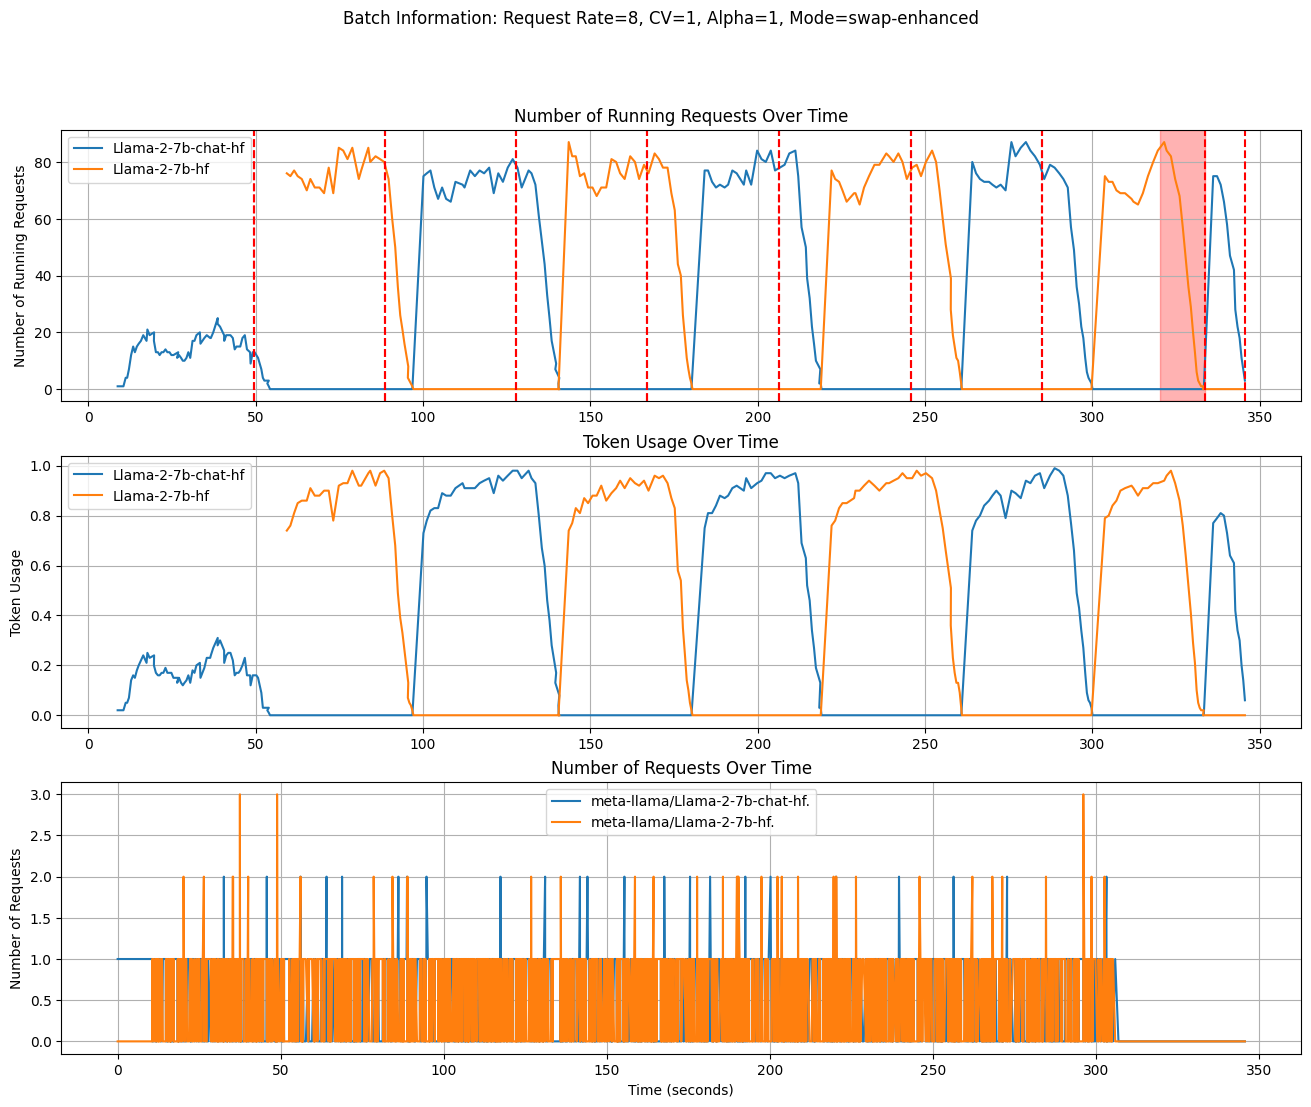

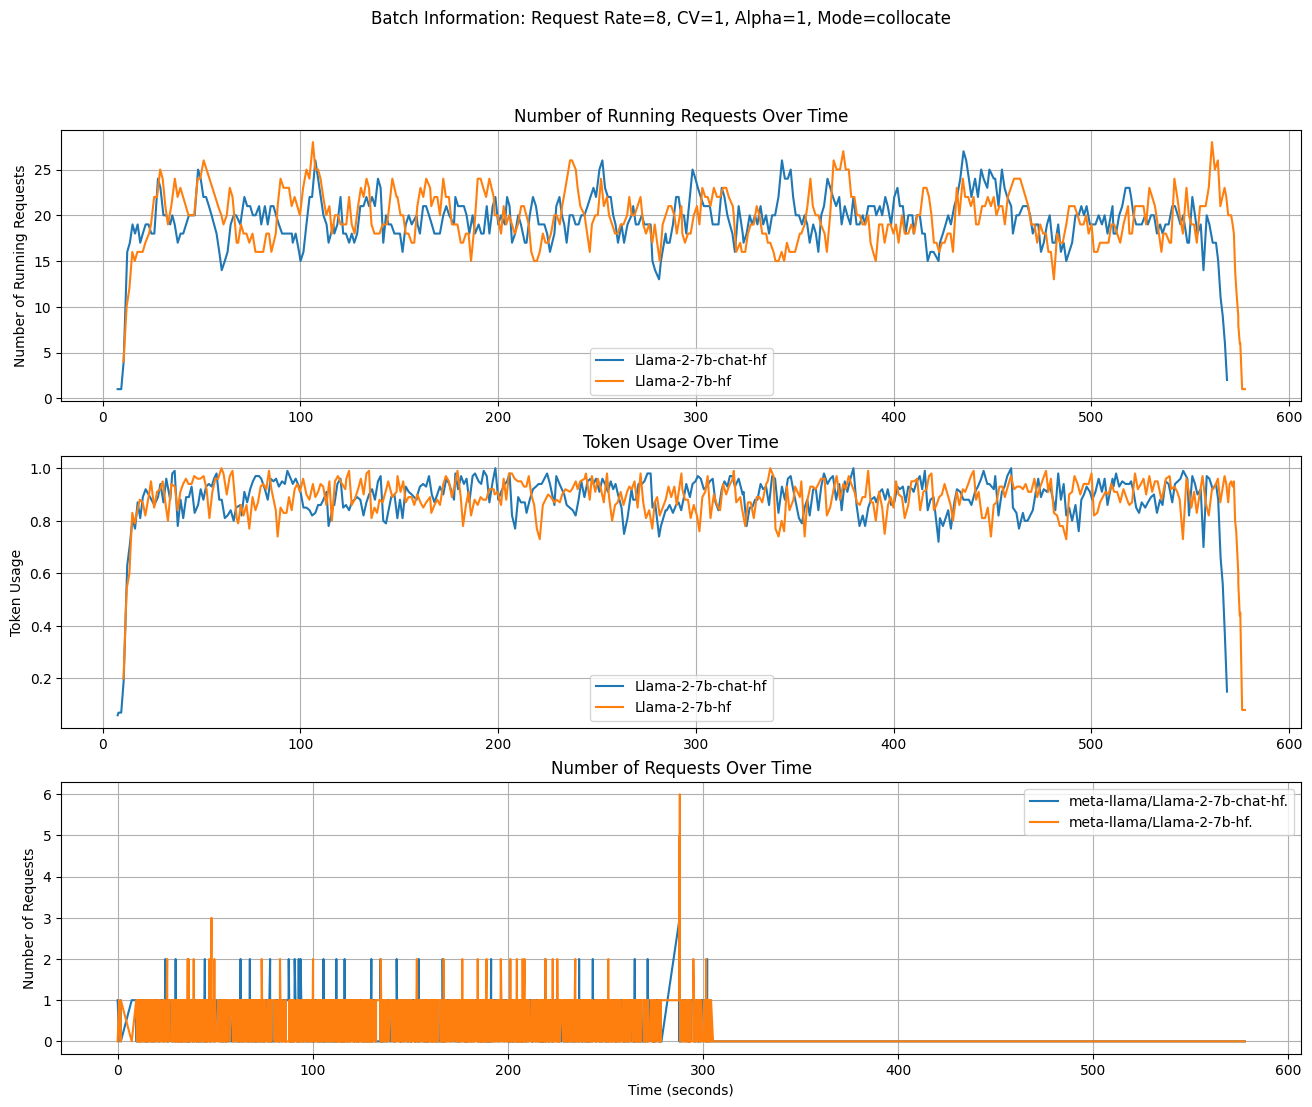

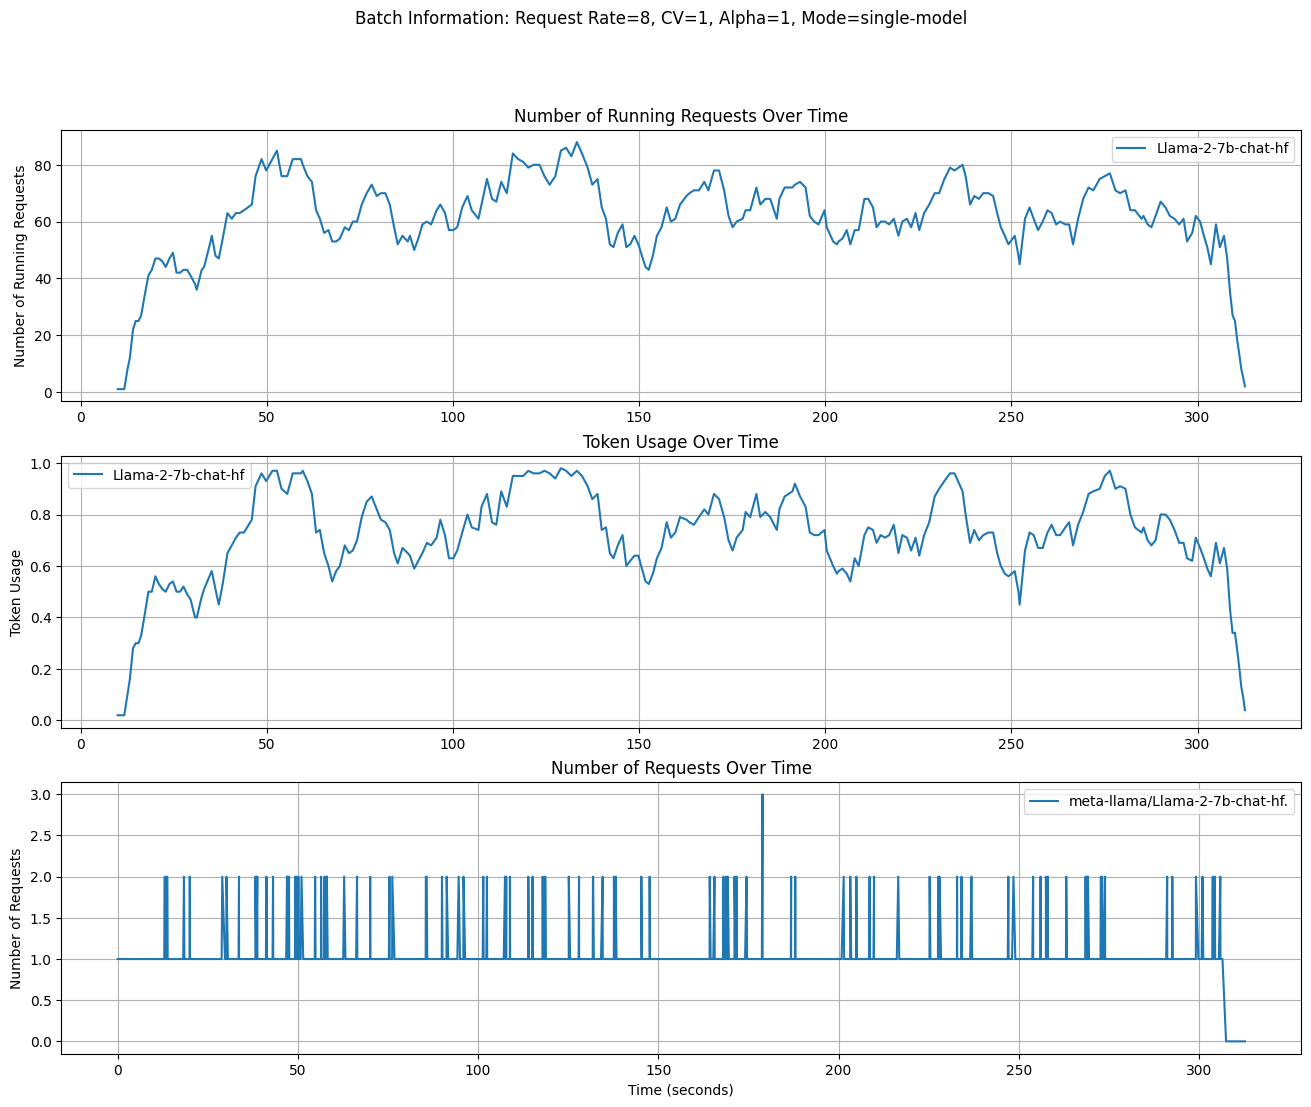

In [61]:
req_rate=8
cv=1
alpha=1

plot_batch_info(req_rate, cv, alpha, "swap-enhanced", server_file_old=False)
plot_batch_info(req_rate, cv, alpha, "collocate", server_file_old=True)
plot_batch_info(req_rate, cv, alpha, "single-model", server_file_old=True)


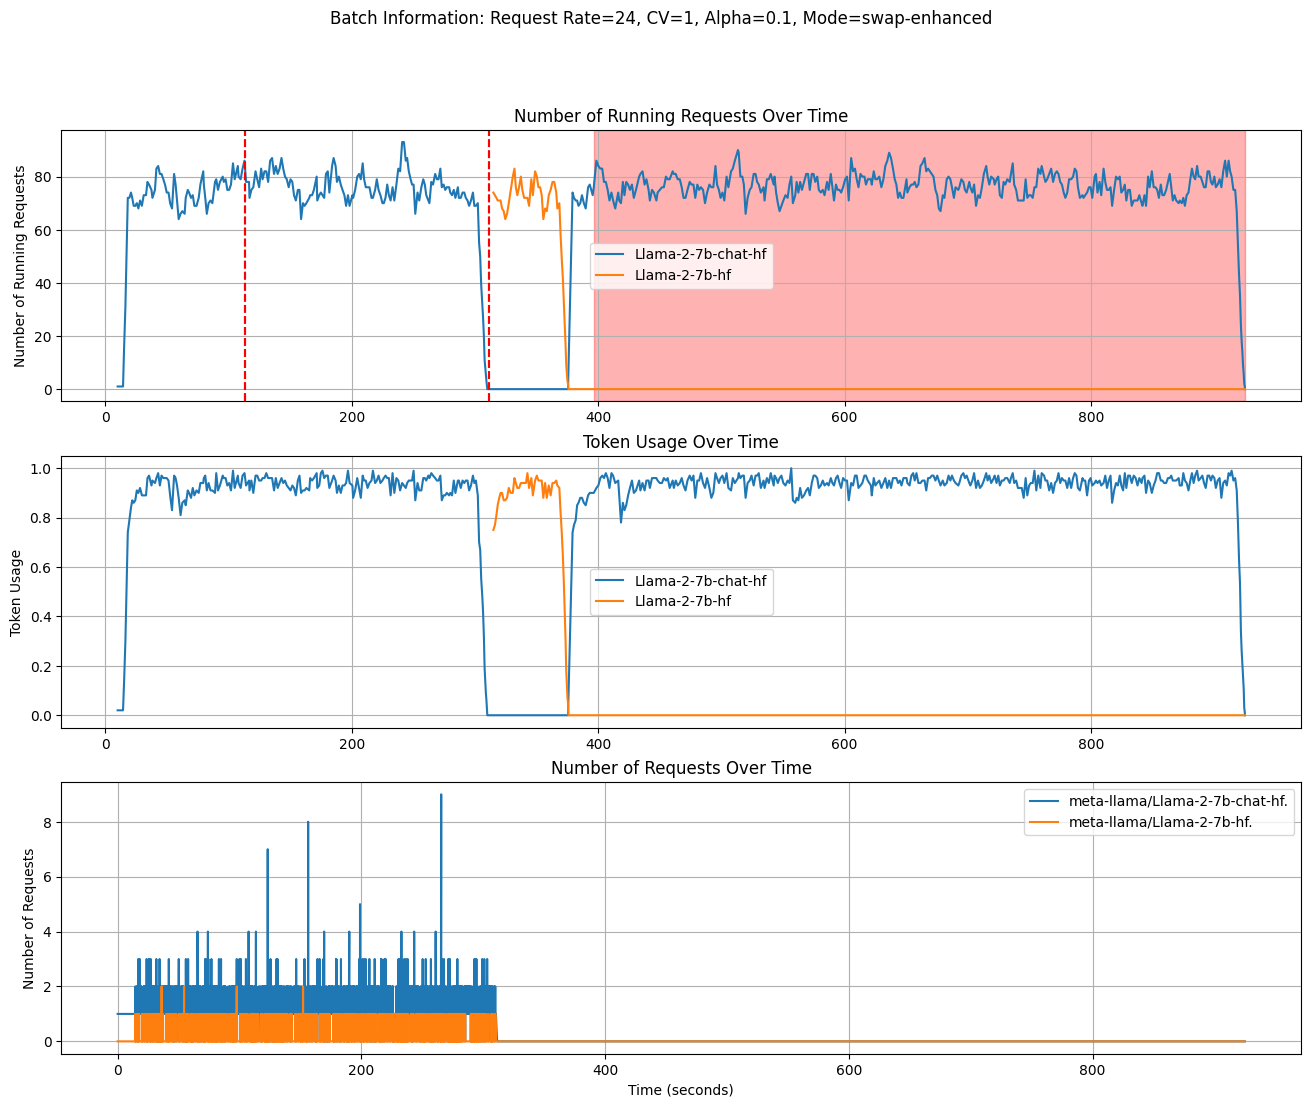

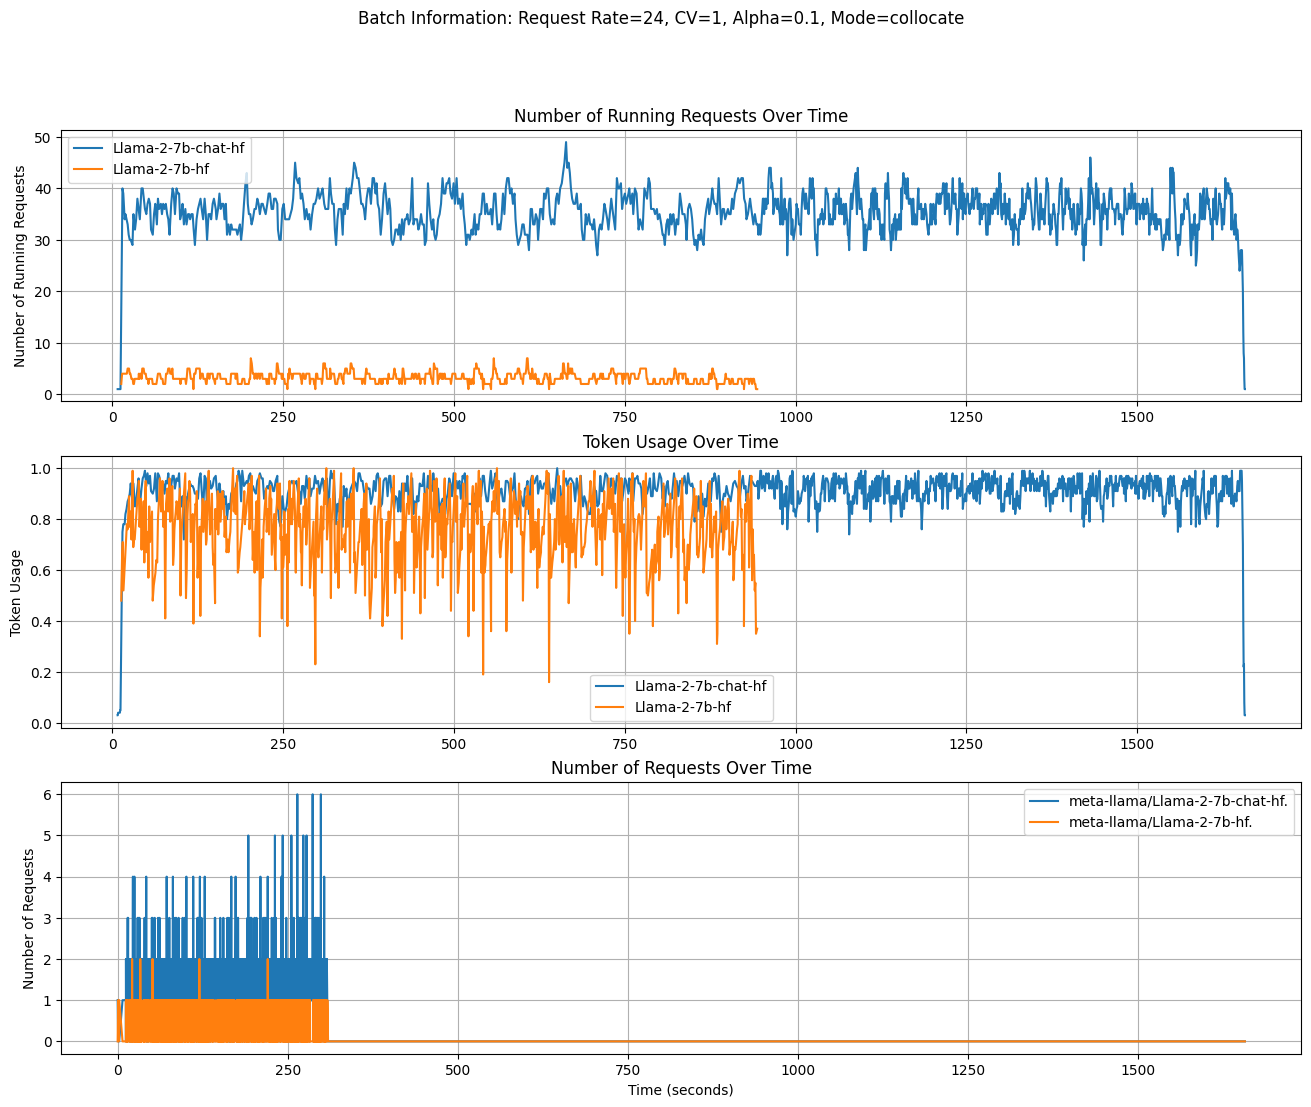

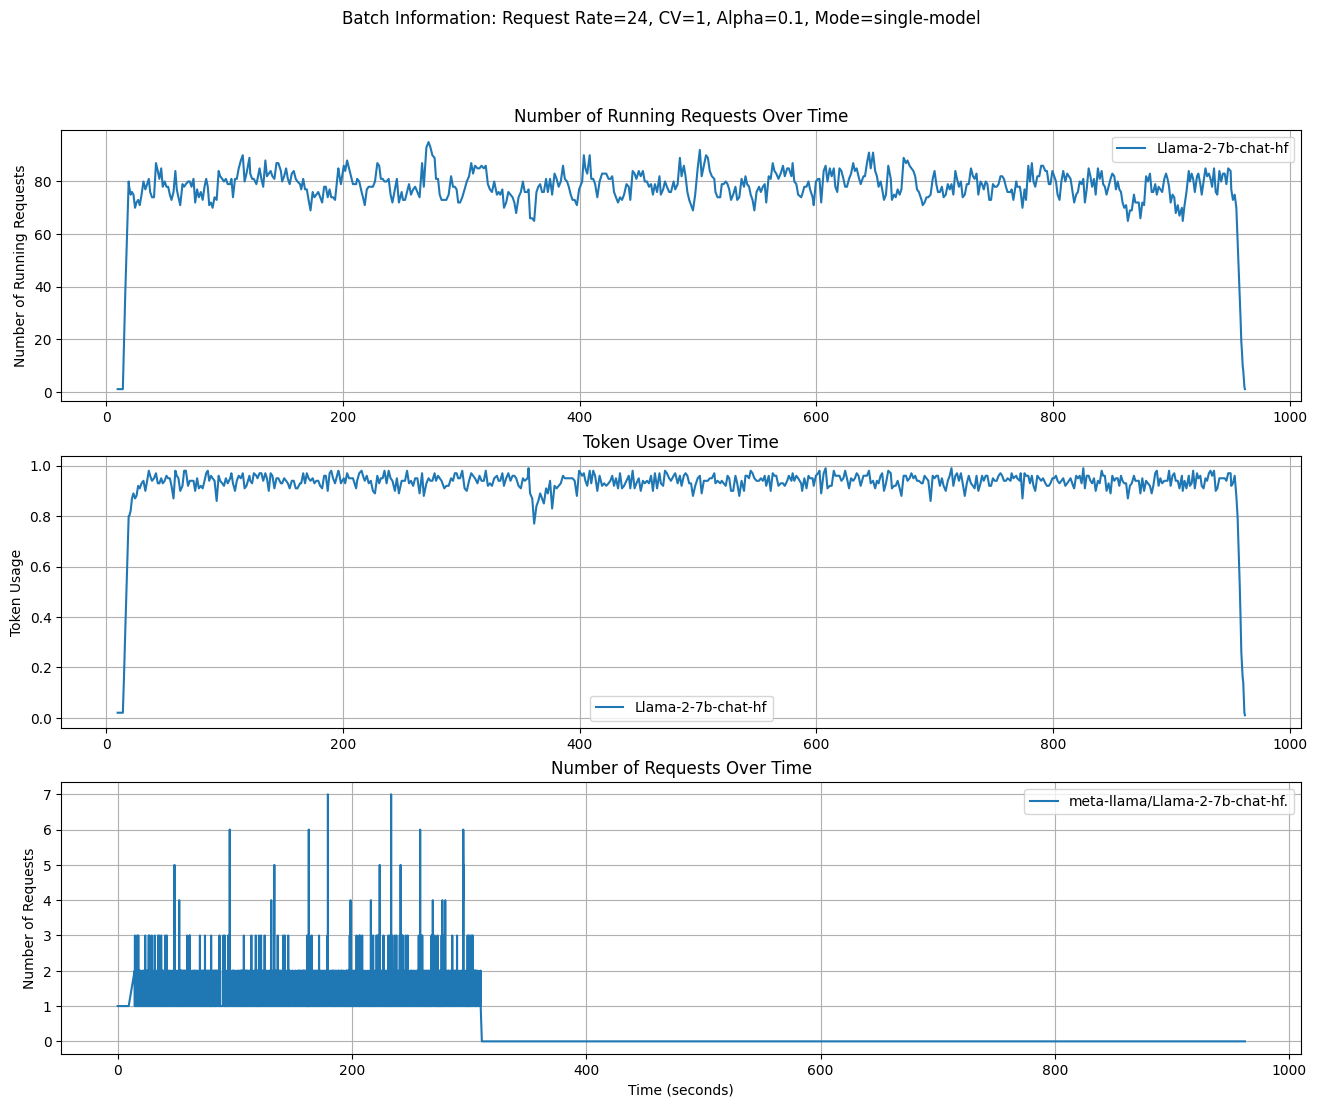

In [62]:
req_rate=24
cv=1
alpha=0.1

plot_batch_info(req_rate, cv, alpha, "swap-enhanced", slo=180, server_file_old=False)
plot_batch_info(req_rate, cv, alpha, "collocate", server_file_old=True)
plot_batch_info(req_rate, cv, alpha, "single-model", server_file_old=True)

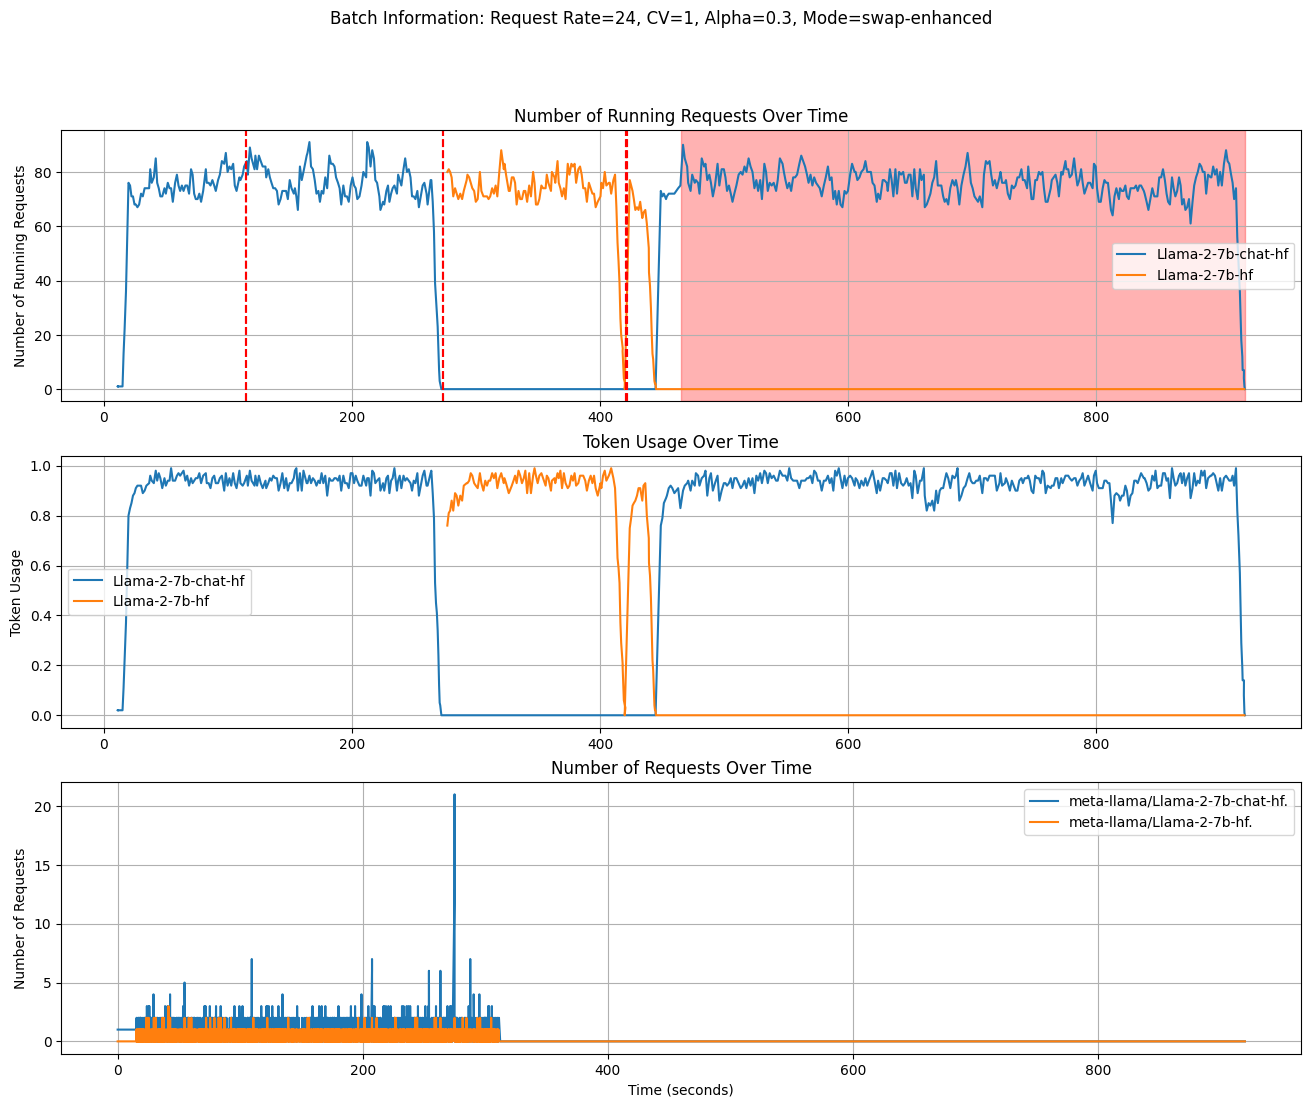

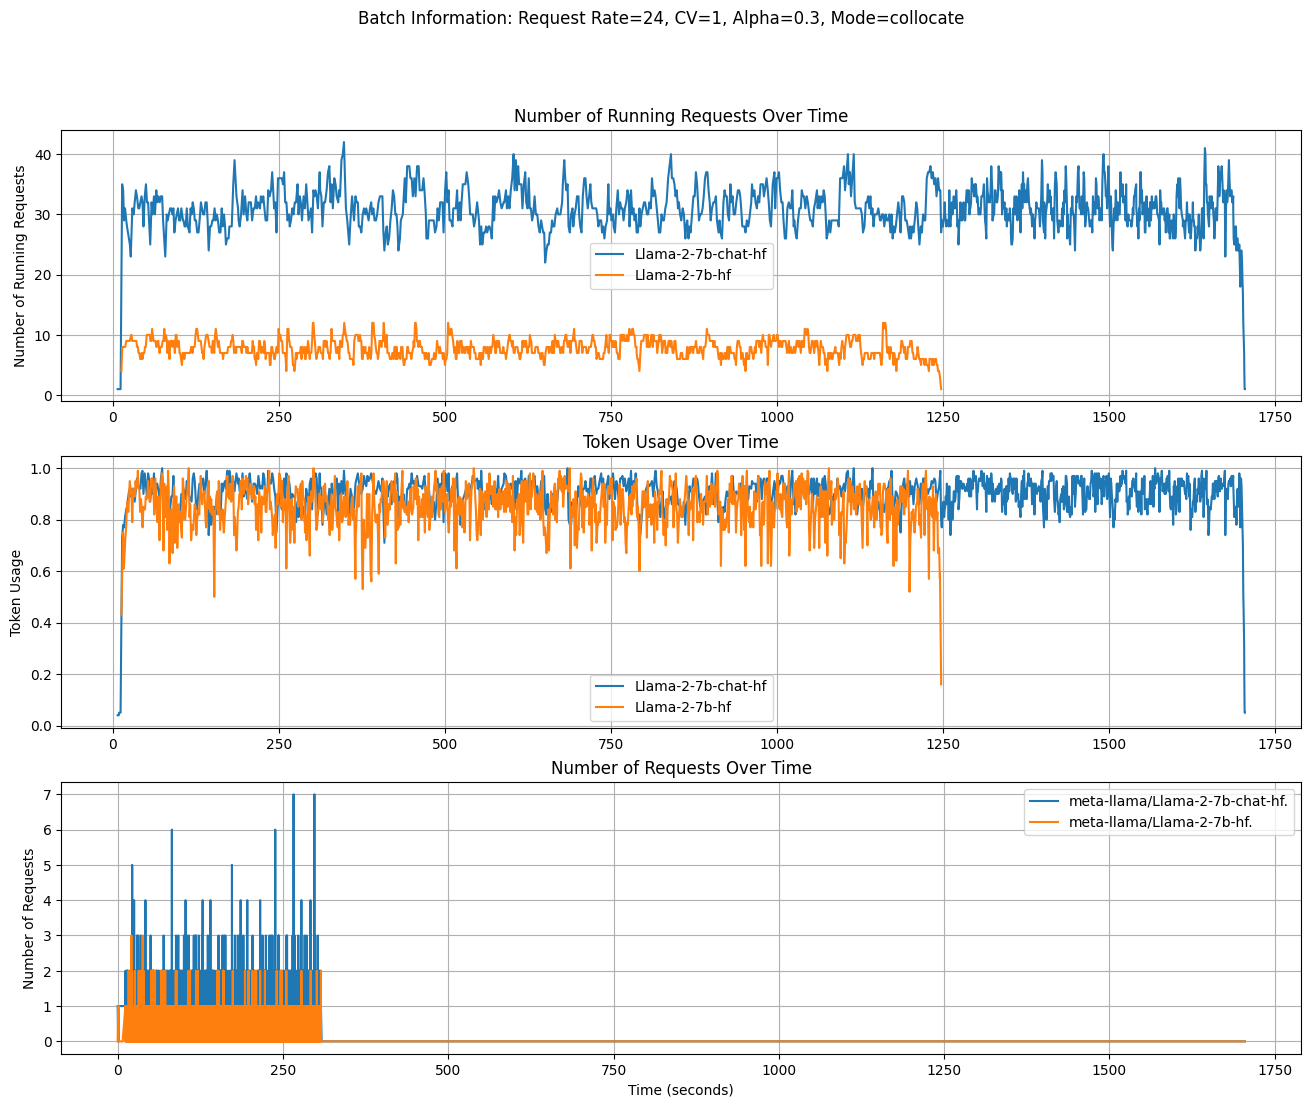

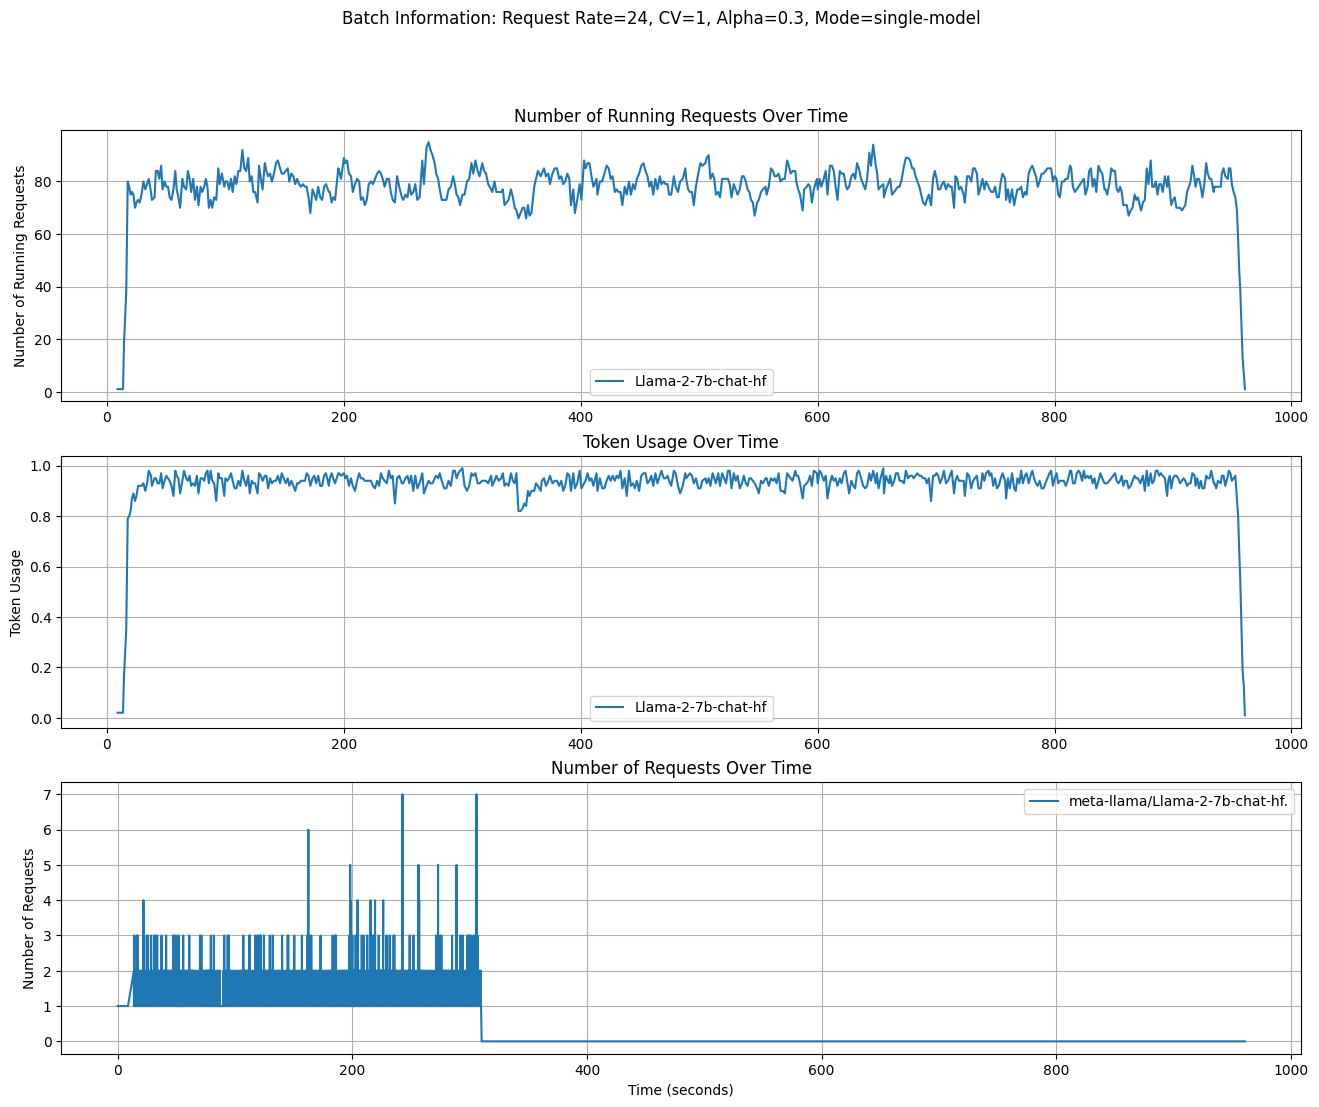

In [63]:
req_rate=24
cv=1
alpha=0.3

plot_batch_info(req_rate, cv, alpha, "swap-enhanced", slo=180, server_file_old=False)
plot_batch_info(req_rate, cv, alpha, "collocate", server_file_old=True)
plot_batch_info(req_rate, cv, alpha, "single-model", server_file_old=True)